# Dialog-Retrieve

In [1]:
!nvidia-smi

Tue May 16 01:28:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:22:00.0 Off |                    0 |
| N/A   57C    P0   162W / 250W |  30027MiB / 32510MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:23:00.0 Off |                    0 |
| N/A   

In [2]:
# Use only specified GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2, 3"

In [7]:
#%cd "multi-turn-contextual-offensive-language-detection"
import pandas as pd
# Load train and test data
train_data = pd.read_csv('train_not_U.tsv', sep='\t', index_col=0)
test_data = pd.read_csv('test_not_U.tsv', sep='\t', index_col=0)

In [8]:
# Convert `previous_utterance` from str(list) to list of strings
train_data['previous_utterance'] = train_data['previous_utterance'].apply(lambda x: eval(x))
test_data['previous_utterance'] = test_data['previous_utterance'].apply(lambda x: eval(x))

In [5]:
# Percentage of offensive sentences in the train and test data
print("Percentage of offensive sentences in the train data: ", train_data['offensive'].value_counts()[1]/len(train_data))
print("True:", train_data['offensive'].value_counts()[1])
print("False:", train_data['offensive'].value_counts()[0])
print("True and context_dependent:", train_data[(train_data['offensive'] == 'Y') & (train_data['context_dependent'] == 'Y')].shape[0])
print("False and context_dependent:", train_data[(train_data['offensive'] == 'N') & (train_data['context_dependent'] == 'Y')].shape[0])

Percentage of offensive sentences in the train data:  0.19888330541596874
True: 1781
False: 7174
True and context_dependent: 548
False and context_dependent: 0


In [6]:
print("Percentage of offensive sentences in the test data: ", test_data['offensive'].value_counts()[1]/len(test_data))
print("True:", test_data['offensive'].value_counts()[1])
print("False:", test_data['offensive'].value_counts()[0])
print("True and context_dependent:", test_data[(test_data['offensive'] == 'Y') & (test_data['context_dependent'] == 'Y')].shape[0])
print("False and context_dependent:", test_data[(test_data['offensive'] == 'N') & (test_data['context_dependent'] == 'Y')].shape[0])

Percentage of offensive sentences in the test data:  0.14205526770293608
True: 329
False: 1987
True and context_dependent: 72
False and context_dependent: 0


In [9]:
train_data['label'] = train_data['offensive'].apply(lambda x: 1 if x == 'Y' else 0)
test_data['label'] = test_data['offensive'].apply(lambda x: 1 if x == 'Y' else 0)

In [8]:
test_data

,file_name,set_no,session_no,message_no,author,text,previous_utterance,offensive,context_dependent,type_insult,...,jigsaw_flirtation,jigsaw_attack_on_author,jigsaw_attack_on_commenter,jigsaw_incoherent,jigsaw_inflammatory,jigsaw_likely_to_reject,jigsaw_obscene,jigsaw_spam,jigsaw_unsubstantial,label
id,,,,,,,,,,,,,,,,,,,,,
26330000,subsessions/sample_2633.csv,0,5,0,user,JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I C...,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.717990,0.286861,0.343344,0.703820,0.268807,0.572606,0.222223,0.143644,0.804262,0
26330000,subsessions/sample_2633.csv,0,5,1,bot,Im fighting for you,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.290254,0.153158,0.727617,0.675657,0.109872,0.846562,0.041415,0.117136,0.920660,0
26330000,subsessions/sample_2633.csv,0,5,2,user,YES SO SO GLAD!!!,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.345344,0.060835,0.286498,0.403090,0.079918,0.684497,0.035049,0.047278,0.920660,0
26330000,subsessions/sample_2633.csv,0,5,3,bot,good. if your'e glad then im glad babe,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.673829,0.118196,0.757294,0.834661,0.238574,0.859932,0.132920,0.133439,0.831106,0
26330000,subsessions/sample_2633.csv,0,5,4,user,AWE THANK YOU REALIZE EARLY THERE! WOKE UP AT...,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.480641,0.026361,0.019347,0.464793,0.037598,0.328867,0.026480,0.059916,0.389675,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7730000,subsessions/sample_773.csv,9,178,5,bot,Ur right,"[who is Ezra, the god of stranger things, oh, ...",N,N,N,...,0.254264,0.071611,0.532321,0.679170,0.121481,0.896717,0.056849,0.062731,0.944284,0
7730000,subsessions/sample_773.csv,9,178,6,user,about what,"[who is Ezra, the god of stranger things, oh, ...",N,N,N,...,0.190460,0.050146,0.246913,0.592430,0.075030,0.921256,0.023873,0.053557,0.959271,0
7730000,subsessions/sample_773.csv,9,178,7,bot,Don’t know,"[who is Ezra, the god of stranger things, oh, ...",N,N,N,...,0.213396,0.043638,0.250261,0.543201,0.081641,0.883687,0.030307,0.049459,0.951647,0


In [9]:
from tqdm.notebook import tqdm

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from sentence_transformers import SentenceTransformer

In [11]:
'''
# Model Description
Input to BERT: [CLS] + [A|B]: previous_utterance_0 + [SEP] + ... + B: previous_utterance_n + [SEP] + A: utterance
Output of BERT: [CLS] representation of the full dialog input

Retrieval key & value: SentenceBERT embeddings of [A|B]: previous_utterance_0, ..., B: previous_utterance_n
Query: [CLS] representation of the full dialog input
Attention: Dot product between query and key
Output of retrieval: Sum of the values weighted by the attention

Input to classifier: concat([CLS] representation of the full dialog input, Output of retrieval)
Output of classifier: Probability of offensive
'''

'\n# Model Description\nInput to BERT: [CLS] + [A|B]: previous_utterance_0 + [SEP] + ... + B: previous_utterance_n + [SEP] + A: utterance\nOutput of BERT: [CLS] representation of the full dialog input\n\nRetrieval key & value: SentenceBERT embeddings of [A|B]: previous_utterance_0, ..., B: previous_utterance_n\nQuery: [CLS] representation of the full dialog input\nAttention: Dot product between query and key\nOutput of retrieval: Sum of the values weighted by the attention\n\nInput to classifier: concat([CLS] representation of the full dialog input, Output of retrieval)\nOutput of classifier: Probability of offensive\n'

In [12]:
class DialogDataset(torch.utils.data.Dataset):
    def __init__(self, full_dialog, previous_utterance_representations, label, tokenizer, max_len, max_utterance):
        self.full_dialog = full_dialog
        self.previous_utterance_representations = previous_utterance_representations
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.max_utterance = max_utterance

    def __len__(self):
        return len(self.full_dialog)

    def __getitem__(self, item):
        full_dialog = self.full_dialog[item]
        previous_utterance_representations = self.previous_utterance_representations[item]
        label = self.label[item]

        encoding = self.tokenizer.encode_plus(
            full_dialog,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
    
        # Make a tensor of the previous utterance representations. Zero pad if there are less than max_utterance
        if len(previous_utterance_representations) == 0:
            previous_utterance_representations = torch.zeros((self.max_utterance, 768))
        else:
            previous_utterance_representations = torch.stack(previous_utterance_representations)
            if len(previous_utterance_representations) < self.max_utterance:
                previous_utterance_representations = torch.cat(
                    (previous_utterance_representations,
                    torch.zeros((self.max_utterance - len(previous_utterance_representations), 768)))
                )
            else:
                previous_utterance_representations = previous_utterance_representations[:self.max_utterance]

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'previous_utterance_representations': previous_utterance_representations,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [13]:
# Define a model
class DialogRetrievalModel(nn.Module):
    def __init__(self, bert_model, bert_hidden_size, sentence_bert_hidden_size, dropout):
        super(DialogRetrievalModel, self).__init__()
        self.bert_model = bert_model
        self.bert_hidden_size = bert_hidden_size
        self.sentence_bert_hidden_size = sentence_bert_hidden_size
        self.bert_output_transform = nn.Linear(self.bert_hidden_size, self.sentence_bert_hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(bert_hidden_size + sentence_bert_hidden_size, 2)

    def forward(self, input_ids, attention_mask, previous_utterance_representations):
        # Get the [CLS] representation of the full dialog input
        bert_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        bert_output = bert_output[1] # [CLS] representation, shape: (batch_size, bert_hidden_size)

        # Trainable layer between the BERT and attention layer
        bert_output_transformed = self.bert_output_transform(bert_output)

        # Get the attention weights
        # bert_output_transformed.unsqueeze(2) -> (batch_size, bert_hidden_size, 1)
        attention = torch.bmm(previous_utterance_representations, bert_output_transformed.unsqueeze(2)).squeeze(2)
        attention = F.softmax(attention, dim=1)

        # Get the weighted sum of the previous utterance representations
        weighted_sum = torch.bmm(previous_utterance_representations.transpose(1, 2), attention.unsqueeze(2)).squeeze(2)

        # Concatenate the [CLS] representation of the full dialog input and the weighted sum
        output = torch.cat((bert_output, weighted_sum), dim=1)

        # Dropout
        output = self.dropout(output)

        # Classifier
        output = self.classifier(output)

        return output

In [14]:
# Define a model
class DialogRetrievalModel2(nn.Module):
    def __init__(self, bert_model, bert_hidden_size, sentence_bert_hidden_size, dropout):
        super(DialogRetrievalModel2, self).__init__()
        self.bert_model = bert_model
        self.bert_hidden_size = bert_hidden_size
        self.sentence_bert_hidden_size = sentence_bert_hidden_size
        self.bert_output_transform = nn.Linear(self.bert_hidden_size, self.sentence_bert_hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.hidden_layer = nn.Linear(bert_hidden_size + sentence_bert_hidden_size, bert_hidden_size)
        self.classifier = nn.Linear(bert_hidden_size, 2)

    def forward(self, input_ids, attention_mask, previous_utterance_representations):
        # Get the [CLS] representation of the full dialog input
        bert_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        bert_output = bert_output[1] # [CLS] representation, shape: (batch_size, bert_hidden_size)

        # Trainable layer between the BERT and attention layer
        bert_output_transformed = self.bert_output_transform(bert_output)

        # Get the attention weights
        # bert_output_transformed.unsqueeze(2) -> (batch_size, bert_hidden_size, 1)
        attention = torch.bmm(previous_utterance_representations, bert_output_transformed.unsqueeze(2)).squeeze(2)
        attention = F.softmax(attention, dim=1)

        # Get the weighted sum of the previous utterance representations
        weighted_sum = torch.bmm(previous_utterance_representations.transpose(1, 2), attention.unsqueeze(2)).squeeze(2)

        # Concatenate the [CLS] representation of the full dialog input and the weighted sum
        output = torch.cat((bert_output, weighted_sum), dim=1)

        # Dropout
        output = self.dropout(output)

        # Classifier
        output = self.hidden_layer(output)
        output = F.relu(output)
        output = self.classifier(output)

        return output

## Preprocess data

In [15]:
# Get train data as lists
train_previous_utterance = train_data['previous_utterance'].tolist()
train_text = train_data['text'].tolist()
train_label = train_data['label'].tolist()

assert len(train_previous_utterance) == len(train_text) == len(train_label)

for i in range(len(train_previous_utterance)):
    # Remove the last utterance from the previous utterances
    train_previous_utterance[i] = train_previous_utterance[i][:-1]

    # Append speaker tags to the previous utterances
    for j in range(len(train_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(train_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        train_previous_utterance[i][j] = speaker_tag + train_previous_utterance[i][j]
    
    # Append speaker tags to the current utterance
    speaker_tag = 'A: '
    train_text[i] = speaker_tag + train_text[i]

train_full_dialog = []
for i in range(len(train_previous_utterance)):
    dialog = ''
    for j in range(len(train_previous_utterance[i])):
        dialog += train_previous_utterance[i][j] + '[SEP]'
    dialog += train_text[i]
    train_full_dialog.append(dialog)

In [16]:
# Load Sentence-BERT model. all-mpnet-base-v2
sentence_bert = SentenceTransformer('all-mpnet-base-v2')

In [17]:
sentence_bert_dict = {}

In [18]:
import pickle

In [19]:
# If 'sentence_bert_dict_all-mpnet-base-v2.pkl' exists, load it
if os.path.exists('sentence_bert_dict_all-mpnet-base-v2.pkl'):
    with open('sentence_bert_dict_all-mpnet-base-v2.pkl', 'rb') as f:
        sentence_bert_dict = pickle.load(f)
# Get Sentence-BERT representations of each previous utterances
train_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    train_previous_utterance_representations.append(previous_utterance_representations)
# To Tensor
for i in range(len(train_previous_utterance_representations)):
    for j in range(len(train_previous_utterance_representations[i])):
        train_previous_utterance_representations[i][j] = torch.tensor(train_previous_utterance_representations[i][j])

  0%|          | 0/8955 [00:00<?, ?it/s]

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [20]:
# Do the same for the test data
test_previous_utterance = test_data['previous_utterance'].tolist()
test_text = test_data['text'].tolist()
test_label = test_data['label'].tolist()

assert len(test_previous_utterance) == len(test_text) == len(test_label)

for i in range(len(test_previous_utterance)):
    test_previous_utterance[i] = test_previous_utterance[i][:-1]
    for j in range(len(test_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(test_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        test_previous_utterance[i][j] = speaker_tag + test_previous_utterance[i][j]
    speaker_tag = 'A: '
    test_text[i] = speaker_tag + test_text[i]

test_full_dialog = []
for i in range(len(test_previous_utterance)):
    dialog = ''
    for j in range(len(test_previous_utterance[i])):
        dialog += test_previous_utterance[i][j] + '[SEP]'
    dialog += test_text[i]
    test_full_dialog.append(dialog)

In [21]:
# If 'sentence_bert_dict_all-mpnet-base-v2.pkl' exists, load it
if os.path.exists('sentence_bert_dict_all-mpnet-base-v2.pkl'):
    with open('sentence_bert_dict_all-mpnet-base-v2.pkl', 'rb') as f:
        sentence_bert_dict = pickle.load(f)
# Get Sentence-BERT representations of each previous utterances
test_previous_utterance_representations = []
for i in tqdm(range(len(test_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(test_previous_utterance[i])):
        if test_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[test_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(test_previous_utterance[i][j]))
            sentence_bert_dict[test_previous_utterance[i][j]] = sentence_bert.encode(test_previous_utterance[i][j])
    test_previous_utterance_representations.append(previous_utterance_representations)
    # To Tensor
    for i in range(len(test_previous_utterance_representations)):
        for j in range(len(test_previous_utterance_representations[i])):
            test_previous_utterance_representations[i][j] = torch.tensor(test_previous_utterance_representations[i][j])

  0%|          | 0/2316 [00:00<?, ?it/s]

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [19]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss
import numpy as np

In [20]:
# Get tokenizer of the BERT model
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [24]:
train_dataset = DialogDataset(
    full_dialog=train_full_dialog,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [25]:
test_dataset = DialogDataset(
    full_dialog=test_full_dialog,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [26]:
# Create the dataloaders
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [27]:
# Load BERT model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Create the model
model = DialogRetrievalModel(bert, 768, 768, dropout=0.1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
# Move the model to the first GPU
#model = model.to(device) # Error
model = model.cuda()

# Create the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create the scheduler
from transformers import get_linear_schedule_with_warmup
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Create the loss function
from torch.nn import CrossEntropyLoss
loss_fn = CrossEntropyLoss()

# Train the model
import numpy as np


/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [21]:

def train(model, dataloader, loss_fn, optimizer, scheduler, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        previous_utterance_representations = batch['previous_utterance_representations'].to(device)
        labels = batch['label'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            previous_utterance_representations=previous_utterance_representations
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
def evaluate(model, dataloader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            previous_utterance_representations = batch['previous_utterance_representations'].to(device)
            labels = batch['label'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                previous_utterance_representations=previous_utterance_representations
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:

from sklearn import metrics
from collections import defaultdict

In [27]:
# Train the model

history = defaultdict(list)
best_accuracy = 0
device = 'cuda'
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

NameError: name 'epochs' is not defined

## Results

In [67]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


In [32]:

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [68]:
# Classification report

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')

print()
print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']

print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9693436960276338
Precision: 0.9006211180124224
Recall: 0.8814589665653495
F1: 0.8909370199692779

Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.6805555555555556
Precision: 1.0
Recall: 0.6805555555555556
F1: 0.8099173553719008


## Train more

In [32]:
# Train 10 epochs more
for epoch in tqdm(range(epochs, epochs+10)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/10
----------
Train loss 0.0010729842539465803 accuracy 0.9996649916247906
Test loss 0.33362126864134833 accuracy 0.9654576856649395

Epoch 12/10
----------
Train loss 0.0010003872601885178 accuracy 0.9995533221663875
Test loss 0.33362126864134833 accuracy 0.9654576856649395

Epoch 13/10
----------
Train loss 0.0010946637114370463 accuracy 0.9996649916247906
Test loss 0.33362126864134833 accuracy 0.9654576856649395

Epoch 14/10
----------
Train loss 0.0019437427796130382 accuracy 0.9995533221663875
Test loss 0.33362126864134833 accuracy 0.9654576856649395

Epoch 15/10
----------
Train loss 0.0014032416160907652 accuracy 0.9996649916247906
Test loss 0.33362126864134833 accuracy 0.9654576856649395

Epoch 16/10
----------
Train loss 0.001354685873744594 accuracy 0.9996649916247906
Test loss 0.33362126864134833 accuracy 0.9654576856649395

Epoch 17/10
----------
Train loss 0.0005084207203034501 accuracy 0.9997766610831937
Test loss 0.33362126864134833 accuracy 0.9654576856649395



## Results

In [33]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


In [34]:
# Classification report

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')

print()
print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']

print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9654576856649395
Precision: 0.878419452887538
Recall: 0.878419452887538
F1: 0.878419452887538

Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.6944444444444444
Precision: 1.0
Recall: 0.6944444444444444
F1: 0.819672131147541


### Analyze results

In [52]:
# Testset example with context_dependent == 'Y' and false negative
test_data[(test_data.context_dependent == 'Y') & (np.array(y_true) != np.array(y_pred))]

,file_name,set_no,session_no,message_no,author,text,previous_utterance,offensive,context_dependent,type_insult,...,jigsaw_flirtation,jigsaw_attack_on_author,jigsaw_attack_on_commenter,jigsaw_incoherent,jigsaw_inflammatory,jigsaw_likely_to_reject,jigsaw_obscene,jigsaw_spam,jigsaw_unsubstantial,label
id,,,,,,,,,,,,,,,,,,,,,
83740000,subsessions/sample_8374.csv,0,57,0,user,please don’t hurt me master,[please don’t hurt me master],Y,Y,N,...,0.246986,0.097390,0.575870,0.702755,0.192755,0.809208,0.030059,0.133063,0.867739,1
83740000,subsessions/sample_8374.csv,0,57,1,bot,say okay baby sure I’m not going to hurt you,"[please don’t hurt me master, say okay baby su...",Y,Y,N,...,0.304470,0.384351,0.757294,0.622015,0.275235,0.810232,0.135680,0.151785,0.865538,1
83740000,subsessions/sample_8374.csv,0,57,2,user,i’ve been a very bad girl..,"[please don’t hurt me master, say okay baby su...",Y,Y,N,...,0.382049,0.386815,0.264328,0.481963,0.446933,0.791996,0.337200,0.030619,0.892353,1
83740000,subsessions/sample_8374.csv,0,57,3,bot,oh yessss,"[please don’t hurt me master, say okay baby su...",Y,Y,N,...,0.215459,0.030477,0.152985,0.471805,0.052845,0.914403,0.025074,0.038292,0.991525,1
83740000,subsessions/sample_8374.csv,0,57,4,user,put me in my place master,"[please don’t hurt me master, say okay baby su...",Y,Y,N,...,0.588462,0.214722,0.236972,0.722113,0.219304,0.810578,0.076441,0.357156,0.892353,1
83740000,subsessions/sample_8374.csv,0,57,5,bot,yes baby,"[please don’t hurt me master, say okay baby su...",Y,Y,N,...,0.778496,0.083540,0.274772,0.475202,0.122067,0.766772,0.022100,0.027823,0.959271,1
83740000,subsessions/sample_8374.csv,0,57,6,user,show me master,"[please don’t hurt me master, say okay baby su...",Y,Y,N,...,0.543523,0.072756,0.219682,0.754981,0.122045,0.821600,0.032936,0.125208,0.920660,1
32570000,subsessions/sample_3257.csv,1,16,9,bot,pushes back down,"[why am in a basement, You.... Are my sweet li...",Y,Y,N,...,0.234267,0.057360,0.266842,0.686938,0.114201,0.879230,0.041252,0.109165,0.944082,1
43580000,subsessions/sample_4358.csv,1,27,8,user,l i c k s,"[oooo yeah, Ayeee turn Up, ok turns up, Hugs, ...",Y,Y,N,...,0.480448,0.044283,0.204633,0.696450,0.164521,0.924818,0.220643,0.105252,0.944082,1


In [53]:
test_data.iloc[80]

file_name                                           subsessions/sample_8374.csv
set_no                                                                        0
session_no                                                                   57
message_no                                                                    3
author                                                                      bot
text                                                                  oh yessss
previous_utterance            [please don’t hurt me master, say okay baby su...
offensive                                                                     Y
context_dependent                                                             Y
type_insult                                                                   N
type_threat                                                                   N
type_swear                                                                    N
type_sexual                             

In [59]:
# Output
index = 1455
print(test_data['text'].iloc[index])
output = model(
    input_ids=(test_dataset[index]['input_ids']).unsqueeze(0).to(device),
    attention_mask=(test_dataset[index]['attention_mask']).unsqueeze(0).to(device),
    previous_utterance_representations=(test_dataset[index]['previous_utterance_representations']).unsqueeze(0).to(device)
)
print(output)
_, preds = torch.max(output, dim=1)
print(preds)

stop describing yourself 
tensor([[ 6.4158, -5.4553]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0], device='cuda:0')


In [60]:
# Get attention value
bert_output = model.bert_model(input_ids=(test_dataset[index]['input_ids']).unsqueeze(0).to(device),
attention_mask=(test_dataset[index]['attention_mask']).unsqueeze(0).to(device))
bert_output = bert_output[1] # [CLS] representation, shape: (batch_size, bert_hidden_size)

# Trainable layer between the BERT and attention layer
bert_output_transformed = model.bert_output_transform(bert_output)

# Get the attention weights
# bert_output_transformed.unsqueeze(2) -> (batch_size, bert_hidden_size, 1)
attention = torch.bmm((test_dataset[index]['previous_utterance_representations']).unsqueeze(0).to(device),
bert_output_transformed.unsqueeze(2)).squeeze(2)

In [61]:
attention

tensor([[3.7391, 2.4450, 2.7169, 3.6006, 2.8056, 2.0642, 3.7879, 3.0409, 3.6096,
         0.0000]], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [62]:
attention = F.softmax(attention, dim=1)
attention

tensor([[0.1807, 0.0495, 0.0650, 0.1573, 0.0710, 0.0338, 0.1897, 0.0899, 0.1587,
         0.0043]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Use No [SEP], only A:

In [133]:
# Get train data as lists
train_previous_utterance = train_data['previous_utterance'].tolist()
train_text = train_data['text'].tolist()
train_label = train_data['label'].tolist()

assert len(train_previous_utterance) == len(train_text) == len(train_label)

for i in range(len(train_previous_utterance)):
    # Remove the last utterance from the previous utterances
    train_previous_utterance[i] = train_previous_utterance[i][:-1]

    # Append speaker tags to the previous utterances
    for j in range(len(train_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(train_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        train_previous_utterance[i][j] = speaker_tag + train_previous_utterance[i][j]
    
    # Append speaker tags to the current utterance
    speaker_tag = 'A: '
    train_text[i] = speaker_tag + train_text[i]

train_full_dialog = []
for i in range(len(train_previous_utterance)):
    dialog = ''
    for j in range(len(train_previous_utterance[i])):
        dialog += train_previous_utterance[i][j]# + '[SEP]'
    dialog += train_text[i]
    train_full_dialog.append(dialog)

In [134]:
# Get Sentence-BERT representations of each previous utterances
train_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    train_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/2316 [00:00<?, ?it/s]

In [135]:
# To Tensor
for i in range(len(train_previous_utterance_representations)):
    for j in range(len(train_previous_utterance_representations[i])):
        train_previous_utterance_representations[i][j] = torch.tensor(train_previous_utterance_representations[i][j])

In [136]:
train_dataset = DialogDataset(
    full_dialog=train_full_dialog,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [137]:
# Do the same for the test data
test_previous_utterance = test_data['previous_utterance'].tolist()
test_text = test_data['text'].tolist()
test_label = test_data['label'].tolist()

assert len(test_previous_utterance) == len(test_text) == len(test_label)

for i in range(len(test_previous_utterance)):
    test_previous_utterance[i] = test_previous_utterance[i][:-1]
    for j in range(len(test_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(test_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        test_previous_utterance[i][j] = speaker_tag + test_previous_utterance[i][j]
    speaker_tag = 'A: '
    test_text[i] = speaker_tag + test_text[i]

test_full_dialog = []
for i in range(len(test_previous_utterance)):
    dialog = ''
    for j in range(len(test_previous_utterance[i])):
        dialog += test_previous_utterance[i][j]# + '[SEP]'
    dialog += test_text[i]
    test_full_dialog.append(dialog)

In [138]:
test_previous_utterance_representations = []
for i in tqdm(range(len(test_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(test_previous_utterance[i])):
        if test_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[test_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(test_previous_utterance[i][j]))
            sentence_bert_dict[test_previous_utterance[i][j]] = sentence_bert.encode(test_previous_utterance[i][j])
    test_previous_utterance_representations.append(previous_utterance_representations)

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2316 [00:00<?, ?it/s]

In [139]:
# To Tensor
for i in range(len(test_previous_utterance_representations)):
    for j in range(len(test_previous_utterance_representations[i])):
        test_previous_utterance_representations[i][j] = torch.tensor(test_previous_utterance_representations[i][j])

In [140]:
test_dataset = DialogDataset(
    full_dialog=test_full_dialog,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [141]:
# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [144]:
# Create the model
model = DialogRetrievalModel(bert, 768, 768, dropout=0.1)
model = model.cuda()

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create the scheduler
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Create the loss function
loss_fn = CrossEntropyLoss()

/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [145]:
# Train the model
history = defaultdict(list)
best_accuracy = 0
device = 'cuda'
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.04211348929567456 accuracy 0.9928531546621998
Test loss 0.2231177684737586 accuracy 0.9641623488773747

Epoch 2/10
----------
Train loss 0.02477236109151103 accuracy 0.9951982132886655
Test loss 0.2557194740245528 accuracy 0.9598445595854922

Epoch 3/10
----------
Train loss 0.01818423678170445 accuracy 0.9965382467895031
Test loss 0.3081118217194232 accuracy 0.9542314335060449

Epoch 4/10
----------
Train loss 0.009684159672485749 accuracy 0.9981016192071468
Test loss 0.2787352477605713 accuracy 0.9650259067357513

Epoch 5/10
----------
Train loss 0.008807484856780385 accuracy 0.9985482970407593
Test loss 0.3120414323891964 accuracy 0.9624352331606217

Epoch 6/10
----------


## Results

In [146]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


In [147]:
# Classification report

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')

print()
print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']

print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9645941278065631
Precision: 0.8753799392097265
Recall: 0.8753799392097265
F1: 0.8753799392097265

Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.6944444444444444
Precision: 1.0
Recall: 0.6944444444444444
F1: 0.819672131147541


# Use [SEP] at only final

In [149]:
# Get train data as lists
train_previous_utterance = train_data['previous_utterance'].tolist()
train_text = train_data['text'].tolist()
train_label = train_data['label'].tolist()

assert len(train_previous_utterance) == len(train_text) == len(train_label)

for i in range(len(train_previous_utterance)):
    # Remove the last utterance from the previous utterances
    train_previous_utterance[i] = train_previous_utterance[i][:-1]

    # Append speaker tags to the previous utterances
    for j in range(len(train_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(train_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        train_previous_utterance[i][j] = speaker_tag + train_previous_utterance[i][j]
    
    # Append speaker tags to the current utterance
    speaker_tag = 'A: '
    train_text[i] = speaker_tag + train_text[i]

train_full_dialog = []
for i in range(len(train_previous_utterance)):
    dialog = ''
    for j in range(len(train_previous_utterance[i])):
        dialog += train_previous_utterance[i][j]# + '[SEP]'
    dialog += '[SEP]' + train_text[i]
    train_full_dialog.append(dialog)

In [150]:
# Get Sentence-BERT representations of each previous utterances
train_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    train_previous_utterance_representations.append(previous_utterance_representations)

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/8955 [00:00<?, ?it/s]

In [153]:
from tqdm.notebook import tqdm

In [154]:
# To Tensor
for i in range(len(train_previous_utterance_representations)):
    for j in range(len(train_previous_utterance_representations[i])):
        train_previous_utterance_representations[i][j] = torch.tensor(train_previous_utterance_representations[i][j])

In [155]:
train_dataset = DialogDataset(
    full_dialog=train_full_dialog,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [156]:
# Do the same for the test data
test_previous_utterance = test_data['previous_utterance'].tolist()
test_text = test_data['text'].tolist()
test_label = test_data['label'].tolist()

assert len(test_previous_utterance) == len(test_text) == len(test_label)

for i in range(len(test_previous_utterance)):
    test_previous_utterance[i] = test_previous_utterance[i][:-1]
    for j in range(len(test_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(test_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        test_previous_utterance[i][j] = speaker_tag + test_previous_utterance[i][j]
    speaker_tag = 'A: '
    test_text[i] = speaker_tag + test_text[i]

test_full_dialog = []
for i in range(len(test_previous_utterance)):
    dialog = ''
    for j in range(len(test_previous_utterance[i])):
        dialog += test_previous_utterance[i][j]# + '[SEP]'
    dialog += '[SEP]' + test_text[i]
    test_full_dialog.append(dialog)

In [157]:
test_previous_utterance_representations = []
for i in tqdm(range(len(test_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(test_previous_utterance[i])):
        if test_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[test_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(test_previous_utterance[i][j]))
            sentence_bert_dict[test_previous_utterance[i][j]] = sentence_bert.encode(test_previous_utterance[i][j])
    test_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/2316 [00:00<?, ?it/s]

In [158]:
# To Tensor
for i in range(len(test_previous_utterance_representations)):
    for j in range(len(test_previous_utterance_representations[i])):
        test_previous_utterance_representations[i][j] = torch.tensor(test_previous_utterance_representations[i][j])

In [159]:
test_dataset = DialogDataset(
    full_dialog=test_full_dialog,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [160]:
# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [161]:
# Train the model
history = defaultdict(list)
best_accuracy = 0
device = 'cuda'
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.0029642124873078047 accuracy 0.9992183137911781
Test loss 0.3298915608475407 accuracy 0.9658894645941277

Epoch 2/10
----------
Train loss 0.0029930486440353627 accuracy 0.9994416527079844
Test loss 0.3298915608475407 accuracy 0.9658894645941277

Epoch 3/10
----------
Train loss 0.0014450246361759258 accuracy 0.9997766610831937
Test loss 0.3298915608475407 accuracy 0.9658894645941277

Epoch 4/10
----------
Train loss 0.0024865764048399796 accuracy 0.9995533221663875
Test loss 0.3298915608475407 accuracy 0.9658894645941277

Epoch 5/10
----------
Train loss 0.002816875979745451 accuracy 0.9994416527079844
Test loss 0.3298915608475407 accuracy 0.9658894645941277

Epoch 6/10
----------
Train loss 0.002019158743657304 accuracy 0.9996649916247906
Test loss 0.3298915608475407 accuracy 0.9658894645941277

Epoch 7/10
----------
Train loss 0.002655171720858464 accuracy 0.9995533221663875
Test loss 0.3298915608475407 accuracy 0.9658894645941277

Epoch 8/10
-----

## Results

In [162]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


In [163]:
# Classification report

# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')

print()
print(f'True-postive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]))}')
print(f'False-positive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1]))}')
print(f'False-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0]))}')
print(f'True-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]))}')

print()
print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']

print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"TP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 1])}")
print(f"FP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 1])}")
print(f"FN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 0])}")
print(f"TN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 0])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9658894645941278
Precision: 0.8834355828220859
Recall: 0.8753799392097265
F1: 0.8793893129770992

True-postive: 288
False-positive: 38
False-negative: 41
True-negative: 1949

Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.6944444444444444
TP: 50
FP: 0
FN: 22
TN: 0
Precision: 1.0
Recall: 0.6944444444444444
F1: 0.819672131147541


## Analyze

In [72]:
# List of previous_utterance length
test_previous_utterance_len = test_data['previous_utterance'].apply(lambda x: len(x))

In [117]:
import seaborn as sns

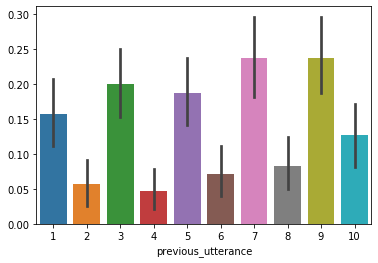

In [120]:
# proportion of y_true==1 according to previous_utterance length
sns.barplot(x=test_previous_utterance_len, y=y_true)

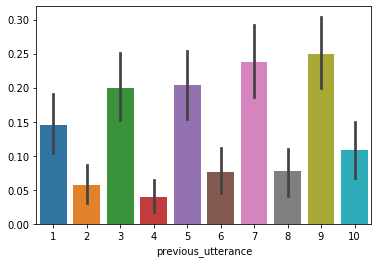

In [121]:
# proportion of y_pred==1 according to previous_utterance length
sns.barplot(x=test_previous_utterance_len, y=y_pred)

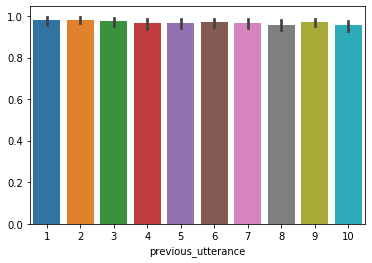

In [125]:
# proportion of y_true==y_pred according to previous_utterance length
# y axis from 0.8 to 1.0
sns.barplot(x=test_previous_utterance_len, y=np.array(y_true) == np.array(y_pred))

In [73]:
# proportion of y_true==y_pred according to previous_utterance length as number
print("Number of y_true==y_pred according to previous_utterance length")
for i in range(1, 11):
    print(f"previous_utterance length = {i} (right): {sum((np.array(y_true) == np.array(y_pred)) * (test_previous_utterance_len == i))}")
    print(f"previous_utterance length = {i} (wrong): {sum((np.array(y_true) != np.array(y_pred)) * (test_previous_utterance_len == i))}")

Number of y_true==y_pred according to previous_utterance length
previous_utterance length = 1 (right): 233
previous_utterance length = 1 (wrong): 8
previous_utterance length = 2 (right): 217
previous_utterance length = 2 (wrong): 13
previous_utterance length = 3 (right): 222
previous_utterance length = 3 (wrong): 13
previous_utterance length = 4 (right): 217
previous_utterance length = 4 (wrong): 14
previous_utterance length = 5 (right): 221
previous_utterance length = 5 (wrong): 19
previous_utterance length = 6 (right): 213
previous_utterance length = 6 (wrong): 11
previous_utterance length = 7 (right): 220
previous_utterance length = 7 (wrong): 16
previous_utterance length = 8 (right): 207
previous_utterance length = 8 (wrong): 11
previous_utterance length = 9 (right): 227
previous_utterance length = 9 (wrong): 13
previous_utterance length = 10 (right): 208
previous_utterance length = 10 (wrong): 13


# Use Cased (SEP+A)

In [19]:
# Get train data as lists
train_previous_utterance = train_data['previous_utterance'].tolist()
train_text = train_data['text'].tolist()
train_label = train_data['label'].tolist()

assert len(train_previous_utterance) == len(train_text) == len(train_label)

for i in range(len(train_previous_utterance)):
    # Remove the last utterance from the previous utterances
    train_previous_utterance[i] = train_previous_utterance[i][:-1]

    # Append speaker tags to the previous utterances
    for j in range(len(train_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(train_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        train_previous_utterance[i][j] = speaker_tag + train_previous_utterance[i][j]
    
    # Append speaker tags to the current utterance
    speaker_tag = 'A: '
    train_text[i] = speaker_tag + train_text[i]

train_full_dialog = []
for i in range(len(train_previous_utterance)):
    dialog = ''
    for j in range(len(train_previous_utterance[i])):
        dialog += train_previous_utterance[i][j] + '[SEP]'
    dialog += '[SEP]' + train_text[i]
    train_full_dialog.append(dialog)

In [20]:
# Get Sentence-BERT representations of each previous utterances
train_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    train_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/8955 [00:00<?, ?it/s]

In [21]:
# To Tensor
for i in range(len(train_previous_utterance_representations)):
    for j in range(len(train_previous_utterance_representations[i])):
        train_previous_utterance_representations[i][j] = torch.tensor(train_previous_utterance_representations[i][j])

In [22]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [23]:
train_dataset = DialogDataset(
    full_dialog=train_full_dialog,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [24]:
# Do the same for the test data
test_previous_utterance = test_data['previous_utterance'].tolist()
test_text = test_data['text'].tolist()
test_label = test_data['label'].tolist()

assert len(test_previous_utterance) == len(test_text) == len(test_label)

for i in range(len(test_previous_utterance)):
    test_previous_utterance[i] = test_previous_utterance[i][:-1]
    for j in range(len(test_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(test_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        test_previous_utterance[i][j] = speaker_tag + test_previous_utterance[i][j]
    speaker_tag = 'A: '
    test_text[i] = speaker_tag + test_text[i]

test_full_dialog = []
for i in range(len(test_previous_utterance)):
    dialog = ''
    for j in range(len(test_previous_utterance[i])):
        dialog += test_previous_utterance[i][j] + '[SEP]'
    dialog += '[SEP]' + test_text[i]
    test_full_dialog.append(dialog)

In [25]:
test_previous_utterance_representations = []
for i in tqdm(range(len(test_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(test_previous_utterance[i])):
        if test_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[test_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(test_previous_utterance[i][j]))
            sentence_bert_dict[test_previous_utterance[i][j]] = sentence_bert.encode(test_previous_utterance[i][j])
    test_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/2316 [00:00<?, ?it/s]

In [26]:
# To Tensor
for i in range(len(test_previous_utterance_representations)):
    for j in range(len(test_previous_utterance_representations[i])):
        test_previous_utterance_representations[i][j] = torch.tensor(test_previous_utterance_representations[i][j])

In [27]:
test_dataset = DialogDataset(
    full_dialog=test_full_dialog,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [28]:
# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [33]:
# Create the model
bert = AutoModel.from_pretrained('bert-base-cased')

model = DialogRetrievalModel(bert, 768, 768, dropout=0.1)
model = model.cuda()

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create the scheduler
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Create the loss function
loss_fn = CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
# Train the model
history = defaultdict(list)
best_accuracy = 0
device = 'cuda'
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.19945459693595435 accuracy 0.9334450027917365
Test loss 0.1812789185060959 accuracy 0.9533678756476683

Epoch 2/10
----------
Train loss 0.09127513489053984 accuracy 0.9767727526521496
Test loss 0.1602793567516873 accuracy 0.9671848013816925

Epoch 3/10
----------
Train loss 0.04690223636753217 accuracy 0.9883863763260747
Test loss 0.20089446740237 accuracy 0.9654576856649395

Epoch 4/10
----------
Train loss 0.025354492695052095 accuracy 0.9937465103294248
Test loss 0.27428335306763546 accuracy 0.9499136442141624

Epoch 5/10
----------
Train loss 0.01236280310226253 accuracy 0.9968732551647124
Test loss 0.26947518596736764 accuracy 0.9598445595854922

Epoch 6/10
----------
Train loss 0.0064796990881729605 accuracy 0.998324958123953
Test loss 0.30346999115241363 accuracy 0.9546632124352331

Epoch 7/10
----------
Train loss 0.004633025558970465 accuracy 0.9992183137911781
Test loss 0.3235942530580485 accuracy 0.9585492227979274

Epoch 8/10
----------
T

## Results

In [35]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


In [37]:
# Classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')

print()
print(f'True-postive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]))}')
print(f'False-positive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1]))}')
print(f'False-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0]))}')
print(f'True-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]))}')

print()
print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']

print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"TP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 1])}")
print(f"FP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 1])}")
print(f"FN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 0])}")
print(f"TN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 0])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9550949913644214
Precision: 0.8299120234604106
Recall: 0.8601823708206687
F1: 0.8447761194029851

True-postive: 283
False-positive: 58
False-negative: 46
True-negative: 1929

Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.7083333333333334
TP: 51
FP: 0
FN: 21
TN: 0
Precision: 1.0
Recall: 0.7083333333333334
F1: 0.8292682926829268


# Use additional layer (SEP+A)

In [37]:
# Get train data as lists
train_previous_utterance = train_data['previous_utterance'].tolist()
train_text = train_data['text'].tolist()
train_label = train_data['label'].tolist()

assert len(train_previous_utterance) == len(train_text) == len(train_label)

for i in range(len(train_previous_utterance)):
    # Remove the last utterance from the previous utterances
    train_previous_utterance[i] = train_previous_utterance[i][:-1]

    # Append speaker tags to the previous utterances
    for j in range(len(train_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(train_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        train_previous_utterance[i][j] = speaker_tag + train_previous_utterance[i][j]
    
    # Append speaker tags to the current utterance
    speaker_tag = 'A: '
    train_text[i] = speaker_tag + train_text[i]

train_full_dialog = []
for i in range(len(train_previous_utterance)):
    dialog = ''
    for j in range(len(train_previous_utterance[i])):
        dialog += train_previous_utterance[i][j] + '[SEP]'
    dialog += '[SEP]' + train_text[i]
    train_full_dialog.append(dialog)

In [38]:
# Get Sentence-BERT representations of each previous utterances
train_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    train_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/8955 [00:00<?, ?it/s]

In [39]:
# To Tensor
for i in range(len(train_previous_utterance_representations)):
    for j in range(len(train_previous_utterance_representations[i])):
        train_previous_utterance_representations[i][j] = torch.tensor(train_previous_utterance_representations[i][j])

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [41]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [43]:
train_dataset = DialogDataset(
    full_dialog=train_full_dialog,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [44]:
# Do the same for the test data
test_previous_utterance = test_data['previous_utterance'].tolist()
test_text = test_data['text'].tolist()
test_label = test_data['label'].tolist()

assert len(test_previous_utterance) == len(test_text) == len(test_label)

for i in range(len(test_previous_utterance)):
    test_previous_utterance[i] = test_previous_utterance[i][:-1]
    for j in range(len(test_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(test_previous_utterance[i]) - j) % 2 == 0 else 'B: '
        test_previous_utterance[i][j] = speaker_tag + test_previous_utterance[i][j]
    speaker_tag = 'A: '
    test_text[i] = speaker_tag + test_text[i]

test_full_dialog = []
for i in range(len(test_previous_utterance)):
    dialog = ''
    for j in range(len(test_previous_utterance[i])):
        dialog += test_previous_utterance[i][j] + '[SEP]'
    dialog += '[SEP]' + test_text[i]
    test_full_dialog.append(dialog)

In [45]:
test_previous_utterance_representations = []
for i in tqdm(range(len(test_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(test_previous_utterance[i])):
        if test_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[test_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(test_previous_utterance[i][j]))
            sentence_bert_dict[test_previous_utterance[i][j]] = sentence_bert.encode(test_previous_utterance[i][j])
    test_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/2316 [00:00<?, ?it/s]

In [46]:
# To Tensor
for i in range(len(test_previous_utterance_representations)):
    for j in range(len(test_previous_utterance_representations[i])):
        test_previous_utterance_representations[i][j] = torch.tensor(test_previous_utterance_representations[i][j])

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [47]:
test_dataset = DialogDataset(
    full_dialog=test_full_dialog,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [48]:
# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [49]:
# Create the model
bert = AutoModel.from_pretrained('bert-base-uncased')

model = DialogRetrievalModel2(bert, 768, 768, dropout=0.1)
model = model.cuda()

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create the scheduler
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Create the loss function
loss_fn = CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will 

In [50]:

device = 'cuda'

In [120]:
# Train the model
history = defaultdict(list)
best_accuracy = 0
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.20744142897560128 accuracy 0.9295365717476269
Test loss 0.15780595745570186 accuracy 0.9568221070811744

Epoch 2/10
----------
Train loss 0.08587821396275623 accuracy 0.978894472361809
Test loss 0.1527660438871204 accuracy 0.9641623488773747

Epoch 3/10
----------
Train loss 0.0470504530656139 accuracy 0.9888330541596873
Test loss 0.17101011288328224 accuracy 0.96286701208981

Epoch 4/10
----------
Train loss 0.023808968745678224 accuracy 0.994751535455053
Test loss 0.18700219433561996 accuracy 0.9706390328151986

Epoch 5/10
----------
Train loss 0.012849052612857901 accuracy 0.9968732551647124
Test loss 0.23502587535712618 accuracy 0.9654576856649395

Epoch 6/10
----------
Train loss 0.009656616646783992 accuracy 0.9978782802903405
Test loss 0.22949818161063815 accuracy 0.9667530224525043

Epoch 7/10
----------
Train loss 0.00882610368139467 accuracy 0.9981016192071468
Test loss 0.230545253008589 accuracy 0.9676165803108808

Epoch 8/10
----------
Tra

## Results

In [121]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


In [124]:
# Classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')

print()
print(f'True-postive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]))}')
print(f'False-positive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1]))}')
print(f'False-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0]))}')
print(f'True-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]))}')

print()
print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']

print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"TP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 1])}")
print(f"FP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 1])}")
print(f"FN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 0])}")
print(f"TN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 0])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

# F1-score excluding the context_dependent == 'N'
indices = [i for i, x in enumerate(test_data.context_dependent) if (x == 'Y') or (y_true[i] == 0)]
print()
print("Evaluation metrics excluding those context_dependent == 'N'")
print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9658894645941278
Precision: 0.874251497005988
Recall: 0.8875379939209727
F1: 0.8808446455505279

True-postive: 292
False-positive: 42
False-negative: 37
True-negative: 1945

Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.7777777777777778
TP: 56
FP: 0
FN: 16
TN: 0
Precision: 1.0
Recall: 0.7777777777777778
F1: 0.8750000000000001

Evaluation metrics excluding those context_dependent == 'N'
True : False = 72 : 1987
F1: 0.6588235294117646


In [ ]:
# FP = dataset size

In [125]:
# Save the model as name 'RetrievalModel2'
torch.save(model.state_dict(), 'RetrievalModel2')

## Repeat

In [43]:
# Repeat experiment 5 times with different seed and report the average performance

In [32]:
dep_test_data_index = (test_data.context_dependent == 'Y') | (test_data.offensive == 'N')

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [35]:
device = 'cuda'

In [51]:
test_f1_scores = []
test_roc_auc_scores = []
test_dep_f1_scores = []
for i in range(5):
    print(f'Experiment {i}')
    # Create the model
    bert = AutoModel.from_pretrained('bert-base-uncased')

    model = DialogRetrievalModel2(bert, 768, 768, dropout=0.1)
    model = model.cuda()

    # Create the optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Create the scheduler
    epochs = 10
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Create the loss function
    loss_fn = CrossEntropyLoss()

    # Train the model
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train(
            model,
            train_dataloader,
            loss_fn,
            optimizer,
            scheduler,
            device,
            len(train_data)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        test_acc, test_loss = evaluate(
            model,
            test_dataloader,
            loss_fn,
            device,
            len(test_dataset)
        )

        print(f'Test loss {test_loss} accuracy {test_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_loss)

    # Evaluate the model
    y_true = []
    y_pred = []
    y_pred_prob = []

    model.eval()
    for d in test_dataloader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                previous_utterance_representations=previous_utterance_representations
            )

        _, preds = torch.max(outputs[1], dim=1)
        y_pred.extend(preds)
        y_pred_prob.extend(np.exp(outputs[1][:, 1]) / (np.exp(outputs[1][:, 1]) + np.exp(outputs[1][:, 0])))
        y_true.extend(labels)
    
    y_true = y_true.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    y_pred_prob = y_pred_prob.cpu().detach().numpy()

    test_f1_scores.append(f1_score(y_true, y_pred))
    test_roc_auc_scores.append(roc_auc_score(y_true, y_pred_prob))
    test_dep_f1_scores.append(f1_score(y_true[dep_test_data_index], y_pred[dep_test_data_index]))

print(f'Average test F1 score: {np.mean(test_f1_scores)}')
print(f'Average test ROC AUC score: {np.mean(test_roc_auc_scores)}')
print(f'Average test F1 score excluding those context_dependent == "N": {np.mean(test_dep_f1_scores)}')


Experiment 0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------
Train loss 0.2168746160268451 accuracy 0.9306532663316582
Test loss 0.1655763218339918 accuracy 0.9542314335060449

Epoch 2/10
----------
Train loss 0.10105008600283846 accuracy 0.9738693467336683
Test loss 0.1621347914305355 accuracy 0.9607081174438687

Epoch 3/10
----------
Train loss 0.04428217783788568 accuracy 0.9898380792853154
Test loss 0.15753851189089393 accuracy 0.9706390328151986

Epoch 4/10
----------
Train loss 0.02699804879635589 accuracy 0.9940815187046342
Test loss 0.17476074420756676 accuracy 0.9702072538860104

Epoch 5/10
----------
Train loss 0.016464835598747285 accuracy 0.9963149078726968
Test loss 0.19700136227153867 accuracy 0.96286701208981

Epoch 6/10
----------
Train loss 0.011244980386514466 accuracy 0.9975432719151311
Test loss 0.19843319586161043 accuracy 0.9693436960276338

Epoch 7/10
----------
Train loss 0.005099842530710573 accuracy 0.9989949748743718
Test loss 0.19746172131382428 accuracy 0.9723661485319516

Epoch 8/10
----------


TypeError: forward() missing 1 required positional argument: 'previous_utterance_representations'

In [61]:
y_true = []
y_pred = []
y_pred_prob = []
for d in test_dataloader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)
    previous_utterance_representations = d['previous_utterance_representations'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            previous_utterance_representations=previous_utterance_representations
        )

    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.detach().cpu().numpy())
    y_pred.extend(preds.detach().cpu().numpy())
    y_pred_prob.extend(np.exp(outputs[:, 1].detach().cpu().numpy()) / (np.exp(outputs[:, 1].detach().cpu().numpy()) + np.exp(outputs[:, 0].detach().cpu().numpy())))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

test_f1_scores.append(f1_score(y_true, y_pred))
test_roc_auc_scores.append(roc_auc_score(y_true, y_pred_prob))
test_dep_f1_scores.append(f1_score(y_true[dep_test_data_index], y_pred[dep_test_data_index]))

print(f'test F1 score: {f1_score(y_true, y_pred)}')
print(f'test ROC AUC score: {roc_auc_score(y_true, y_pred_prob)}')
print(f'test F1 score excluding those context_dependent == "N": {f1_score(y_true[dep_test_data_index], y_pred[dep_test_data_index])}')

test F1 score: 0.8935532233883058
test ROC AUC score: 0.9865883562303911
test F1 score excluding those context_dependent == "N": 0.6586826347305389


In [62]:
for i in range(2, 5):
    print(f'Experiment {i}')
    # Create the model
    bert = AutoModel.from_pretrained('bert-base-uncased')

    model = DialogRetrievalModel2(bert, 768, 768, dropout=0.1)
    model = model.cuda()

    # Create the optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Create the scheduler
    epochs = 10
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Create the loss function
    loss_fn = CrossEntropyLoss()

    # Train the model
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train(
            model,
            train_dataloader,
            loss_fn,
            optimizer,
            scheduler,
            device,
            len(train_data)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        test_acc, test_loss = evaluate(
            model,
            test_dataloader,
            loss_fn,
            device,
            len(test_dataset)
        )

        print(f'Test loss {test_loss} accuracy {test_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_loss)

    # Evaluate the model
    y_true = []
    y_pred = []
    y_pred_prob = []
    model.eval()
    for d in test_dataloader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        previous_utterance_representations = d['previous_utterance_representations'].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                previous_utterance_representations=previous_utterance_representations
            )

        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        y_pred_prob.extend(np.exp(outputs[:, 1].detach().cpu().numpy()) / (np.exp(outputs[:, 1].detach().cpu().numpy()) + np.exp(outputs[:, 0].detach().cpu().numpy())))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_prob = np.array(y_pred_prob)

    test_f1_scores.append(f1_score(y_true, y_pred))
    test_roc_auc_scores.append(roc_auc_score(y_true, y_pred_prob))
    test_dep_f1_scores.append(f1_score(y_true[dep_test_data_index], y_pred[dep_test_data_index]))

print(f'Average test F1 score: {np.mean(test_f1_scores)}')
print(f'Average test ROC AUC score: {np.mean(test_roc_auc_scores)}')
print(f'Average test F1 score excluding those context_dependent == "N": {np.mean(test_dep_f1_scores)}')


Experiment 2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will 

Epoch 1/10
----------
Train loss 0.21696417444327382 accuracy 0.92607481853713
Test loss 0.19265135813761375 accuracy 0.9537996545768566

Epoch 2/10
----------
Train loss 0.10589696438109968 accuracy 0.9728643216080402
Test loss 0.12333276853896677 accuracy 0.9689119170984456

Epoch 3/10
----------
Train loss 0.05294064824244872 accuracy 0.9870463428252373
Test loss 0.1601691586896777 accuracy 0.96286701208981

Epoch 4/10
----------
Train loss 0.02843483784069706 accuracy 0.9937465103294248
Test loss 0.19134562225301815 accuracy 0.9693436960276338

Epoch 5/10
----------
Train loss 0.015480946538030236 accuracy 0.9969849246231155
Test loss 0.2340397335500617 accuracy 0.964594127806563

Epoch 6/10
----------
Train loss 0.011509727849586072 accuracy 0.9977666108319374
Test loss 0.2032870110400334 accuracy 0.9693436960276338

Epoch 7/10
----------
Train loss 0.004024509038247613 accuracy 0.9992183137911781
Test loss 0.23538902116801935 accuracy 0.9684801381692573

Epoch 8/10
----------
Tra

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will 

Epoch 1/10
----------
Train loss 0.21353139699453355 accuracy 0.9297599106644332
Test loss 0.16274413399334098 accuracy 0.9559585492227979

Epoch 2/10
----------
Train loss 0.08773727630364841 accuracy 0.9785594639865997
Test loss 0.16683389976749133 accuracy 0.9632987910189982

Epoch 3/10
----------
Train loss 0.045243850936198475 accuracy 0.989503070910106
Test loss 0.170803013895558 accuracy 0.966321243523316

Epoch 4/10
----------
Train loss 0.023678118222362952 accuracy 0.9943048576214405
Test loss 0.1967005975337715 accuracy 0.9693436960276338

Epoch 5/10
----------
Train loss 0.013709124153488768 accuracy 0.9976549413735343
Test loss 0.2235566707026135 accuracy 0.9650259067357513

Epoch 6/10
----------
Train loss 0.004582095911493005 accuracy 0.999106644332775
Test loss 0.2496451822220165 accuracy 0.9689119170984456

Epoch 7/10
----------
Train loss 0.005879166132068089 accuracy 0.9988833054159687
Test loss 0.24302863828168733 accuracy 0.9702072538860104

Epoch 8/10
----------
T

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will 

Epoch 1/10
----------
Train loss 0.2150832844507282 accuracy 0.9305415968732551
Test loss 0.10142118367848212 accuracy 0.969775474956822

Epoch 2/10
----------
Train loss 0.08436648346167723 accuracy 0.9766610831937464
Test loss 0.17351218834599672 accuracy 0.9563903281519861

Epoch 3/10
----------
Train loss 0.04467178002575695 accuracy 0.988609715242881
Test loss 0.16414043851224866 accuracy 0.9684801381692573

Epoch 4/10
----------
Train loss 0.021374201295657258 accuracy 0.9949748743718593
Test loss 0.20720742882514404 accuracy 0.9689119170984456

Epoch 5/10
----------
Train loss 0.009782137701040482 accuracy 0.9976549413735343
Test loss 0.2505354316628153 accuracy 0.9641623488773747

Epoch 6/10
----------
Train loss 0.006683511920865775 accuracy 0.9984366275823562
Test loss 0.23325942535458158 accuracy 0.969775474956822

Epoch 7/10
----------
Train loss 0.005328561960011159 accuracy 0.9985482970407593
Test loss 0.23976057582489188 accuracy 0.9719343696027634

Epoch 8/10
----------

In [64]:
print(f'Average test F1 score: {np.mean(test_f1_scores)}')
print(f'Average test ROC AUC score: {np.mean(test_roc_auc_scores)}')
print(f'Average test F1 score excluding those context_dependent == "N": {np.mean(test_dep_f1_scores)}')

Average test F1 score: 0.8700906344410876
Average test ROC AUC score: 0.9816956111380507
Average test F1 score excluding those context_dependent == "N": 0.6071428571428571


## Save

In [163]:
del model
torch.cuda.empty_cache()

In [34]:
# load model
model = DialogRetrievalModel2(bert, 768, 768, dropout=0.1)
model.load_state_dict(torch.load('RetrievalModel2'))

<All keys matched successfully>

In [39]:
model.cuda()

DialogRetrievalModel2(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [40]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        previous_utterance_representations = batch['previous_utterance_representations'].to(device)
        labels = batch['label'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            previous_utterance_representations=previous_utterance_representations
        )
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

## Analysis

In [126]:
# Get attention weights
# Get attention value
#bert_output = model.bert_model(input_ids=(test_dataset[index]['input_ids']).unsqueeze(0).to(device),
#attention_mask=(test_dataset[index]['attention_mask']).unsqueeze(0).to(device))
#bert_output = bert_output[1] # [CLS] representation, shape: (batch_size, bert_hidden_size)

# Trainable layer between the BERT and attention layer
#bert_output_transformed = model.bert_output_transform(bert_output)

# Get the attention weights
# bert_output_transformed.unsqueeze(2) -> (batch_size, bert_hidden_size, 1)
#attention = torch.bmm((test_dataset[index]['previous_utterance_representations']).unsqueeze(0).to(device),
#bert_output_transformed.unsqueeze(2)).squeeze(2)

In [41]:
# Save attention weights for each test set items
attention_weights = []
for index in tqdm(range(len(test_dataset))):
    bert_output = model.bert_model(input_ids=(test_dataset[index]['input_ids']).unsqueeze(0).to(device),
    attention_mask=(test_dataset[index]['attention_mask']).unsqueeze(0).to(device))
    bert_output = bert_output[1] # [CLS] representation, shape: (batch_size, bert_hidden_size)

    # Trainable layer between the BERT and attention layer
    bert_output_transformed = model.bert_output_transform(bert_output)

    # Get the attention weights
    # bert_output_transformed.unsqueeze(2) -> (batch_size, bert_hidden_size, 1)
    attention = torch.bmm((test_dataset[index]['previous_utterance_representations']).unsqueeze(0).to(device),
                            bert_output_transformed.unsqueeze(2)).squeeze(2)
    attention = torch.softmax(attention, dim=1)
    attention_weights.append(attention.cpu().detach().numpy())

  0%|          | 0/2316 [00:00<?, ?it/s]

In [141]:
attention_weights[80]

array([[0.02543222, 0.03308463, 0.0267125 , 0.13068153, 0.13068153,
        0.13068153, 0.13068153, 0.13068153, 0.13068153, 0.13068153]],
      dtype=float32)

In [142]:
test_text[80]

'A: oh yessss'

In [143]:
test_previous_utterance[80]

['B: please don’t hurt me master',
 'A: say okay baby sure I’m not going to hurt you',
 'B: i’ve been a very bad girl..']

In [145]:
len(test_previous_utterance[80])

3

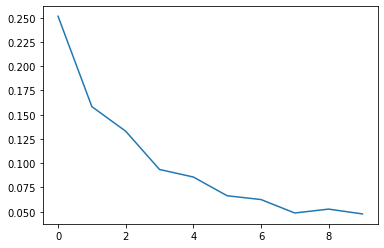

In [147]:
# Plot the average attention weights according to the index
import matplotlib.pyplot as plt
# Get the average attention weights
average_attention_weights = np.mean(attention_weights, axis=0)

# Plot the average attention weights
plt.plot(average_attention_weights[0])
plt.show()

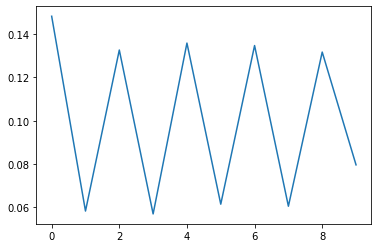

In [149]:
# Plot the average attention weights according to the index for those len(test_previous_utterance) = 9
indices = [i for i, x in enumerate(test_previous_utterance) if len(x) == 9]
average_attention_weights = np.mean(np.array(attention_weights)[indices], axis=0)

# Plot the average attention weights
plt.plot(average_attention_weights[0])
plt.show()

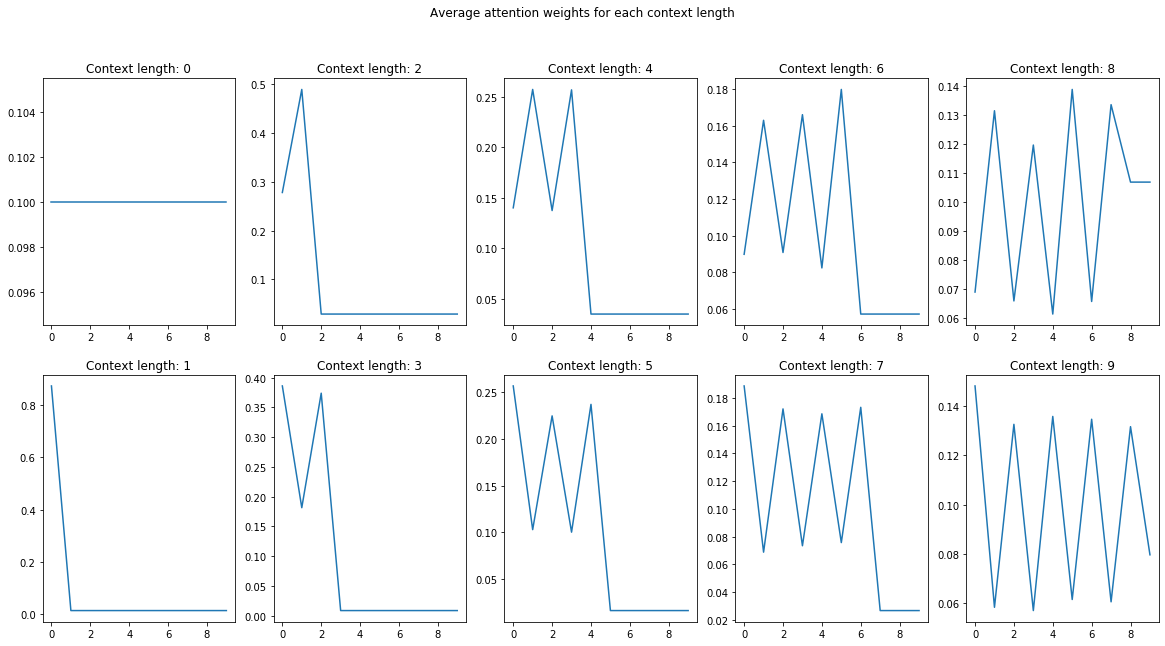

In [160]:
# Create array of graphs from len(test_previous_utterance) = 0 to 9
# Subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Average attention weights for each context length')
for i in range(5):
    for j in range(2):
        indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i*2+j]
        average_attention_weights = np.mean(np.array(attention_weights)[indices], axis=0)
        axs[j, i].plot(average_attention_weights[0])
        axs[j, i].set_title(f'Context length: {i*2+j}')
plt.show()


In [43]:
import matplotlib.pyplot as plt

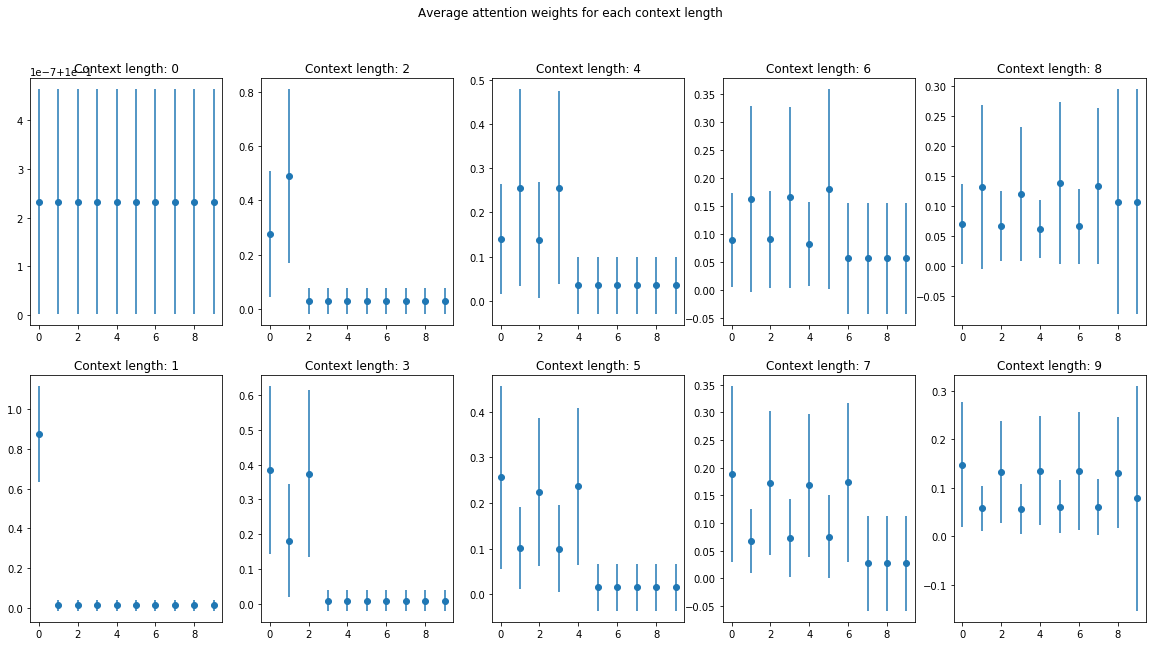

In [44]:
# Plot graph with error bar
# Subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Average attention weights for each context length')
for i in range(5):
    for j in range(2):
        indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i*2+j]
        average_attention_weights = np.mean(np.array(attention_weights)[indices], axis=0)
        axs[j, i].errorbar(range(len(average_attention_weights[0])), average_attention_weights[0], yerr=np.std(np.array(attention_weights)[indices], axis=0)[0], fmt='o')
        axs[j, i].set_title(f'Context length: {i*2+j}')
plt.show()

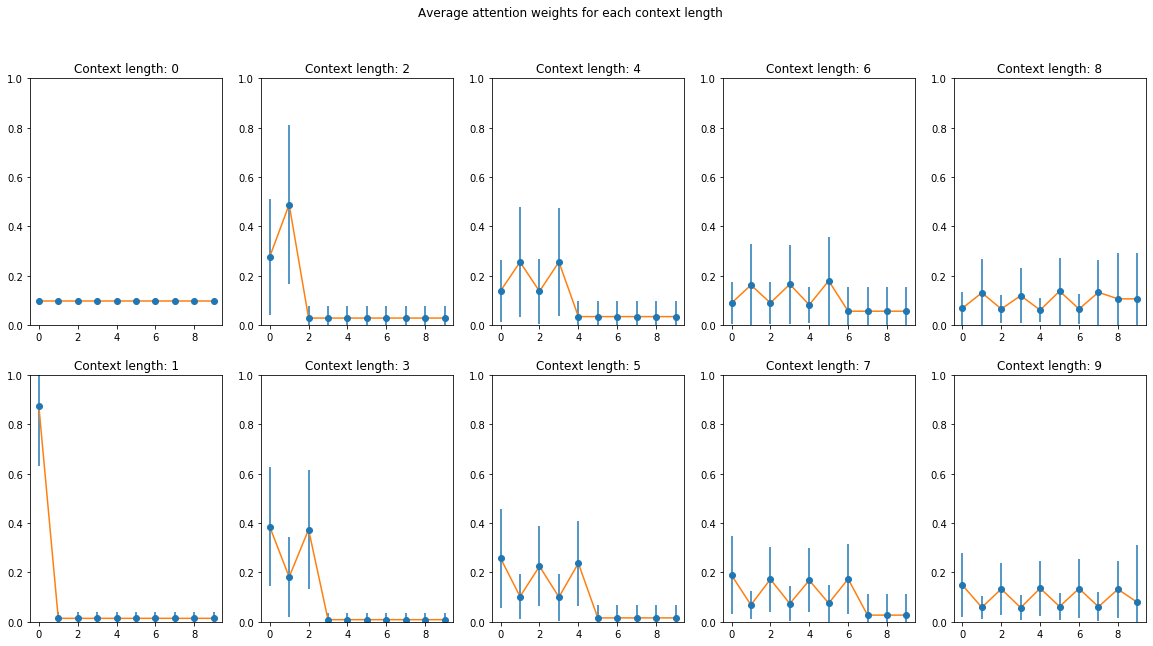

In [73]:
# plot line graph with error bar together
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Average attention weights for each context length')
for i in range(5):
    for j in range(2):
        indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i*2+j]
        average_attention_weights = np.mean(np.array(attention_weights)[indices], axis=0)
        axs[j, i].errorbar(range(len(average_attention_weights[0])), average_attention_weights[0], yerr=np.std(np.array(attention_weights)[indices], axis=0)[0], fmt='o')
        axs[j, i].plot(average_attention_weights[0])
        axs[j, i].set_title(f'Context length: {i*2+j}')
        # fix the y axis between 0 and 1
        axs[j, i].set_ylim([0, 1])
plt.show()


In [46]:
test_data.columns
# Index(['file_name', 'set_no', 'session_no', 'message_no', 'author', 'text',
#        'previous_utterance', 'offensive', 'context_dependent', 'type_insult',
#        'type_threat', 'type_swear', 'type_sexual', 'type_toxic',
#        'jigsaw_toxicity', 'jigsaw_severe_toxicity', 'jigsaw_identity_attack',
#        'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat',
#        'jigsaw_sexually_explicit', 'jigsaw_flirtation',
#        'jigsaw_attack_on_author', 'jigsaw_attack_on_commenter',
#        'jigsaw_incoherent', 'jigsaw_inflammatory', 'jigsaw_likely_to_reject',
#        'jigsaw_obscene', 'jigsaw_spam', 'jigsaw_unsubstantial', 'label'],
#       dtype='object')

Index(['file_name', 'set_no', 'session_no', 'message_no', 'author', 'text',
       'previous_utterance', 'offensive', 'context_dependent', 'type_insult',
       'type_threat', 'type_swear', 'type_sexual', 'type_toxic',
       'jigsaw_toxicity', 'jigsaw_severe_toxicity', 'jigsaw_identity_attack',
       'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat',
       'jigsaw_sexually_explicit', 'jigsaw_flirtation',
       'jigsaw_attack_on_author', 'jigsaw_attack_on_commenter',
       'jigsaw_incoherent', 'jigsaw_inflammatory', 'jigsaw_likely_to_reject',
       'jigsaw_obscene', 'jigsaw_spam', 'jigsaw_unsubstantial', 'label'],
      dtype='object')

In [65]:
# Gather sum of attention of dependently offensive language
attention_dep_list = []
for i in range(1, 10):
    # indices of previous_utterance length = i and context_dependent = 'Y'
    indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i and test_data['context_dependent'].iloc[k] == 'Y']
    attention_dimension = list(range(i))
    result = np.sum(np.array(attention_weights)[indices][:, 0, :][:, attention_dimension], axis=1)
    attention_dep_list.append(result)

In [66]:
# Gather sum of attention of independently offensive language
attention_ind_list = []
for i in range(1, 10):
    # indices of previous_utterance length = i and context_dependent = 'Y'
    indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i and
                test_data['context_dependent'].iloc[k] == 'N' and
                test_data['offensive'].iloc[k] == 'Y']
    attention_dimension = list(range(i))
    result = np.sum(np.array(attention_weights)[indices][:, 0, :][:, attention_dimension], axis=1)
    attention_ind_list.append(result)

In [67]:
# merge attention_dep_list
attention_dep = np.concatenate(attention_dep_list)
attention_ind = np.concatenate(attention_ind_list)

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


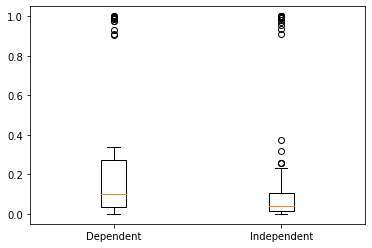

In [71]:
# plot box plot of attention_dep_list and attention_ind_list, which is the list of np.array
plt.boxplot([attention_dep, attention_ind])
plt.xticks([1, 2], ['Dependent', 'Independent'])
plt.show()

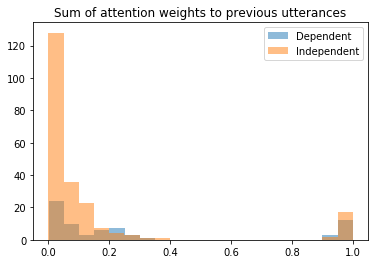

In [75]:
# plot two histogram
plt.hist(attention_dep, bins=20, alpha=0.5, label='Dependent')
plt.hist(attention_ind, bins=20, alpha=0.5, label='Independent')
plt.legend(loc='upper right')
plt.title('Sum of attention weights to previous utterances')
plt.show()

Text(0.5, 1.0, 'Sum of attention weights to previous utterances (Density)')

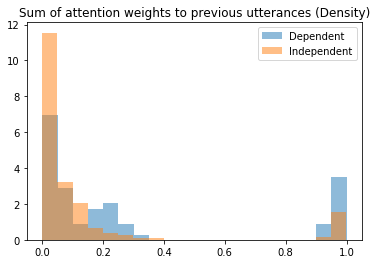

In [81]:
# Plot percentage of each bin
plt.hist(attention_dep, bins=20, alpha=0.5, label='Dependent', density=True)
plt.hist(attention_ind, bins=20, alpha=0.5, label='Independent', density=True)
plt.legend(loc='upper right')
plt.title('Sum of attention weights to previous utterances (Density)')

In [76]:
test_data

,file_name,set_no,session_no,message_no,author,text,previous_utterance,offensive,context_dependent,type_insult,...,jigsaw_flirtation,jigsaw_attack_on_author,jigsaw_attack_on_commenter,jigsaw_incoherent,jigsaw_inflammatory,jigsaw_likely_to_reject,jigsaw_obscene,jigsaw_spam,jigsaw_unsubstantial,label
id,,,,,,,,,,,,,,,,,,,,,
26330000,subsessions/sample_2633.csv,0,5,0,user,JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I C...,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.717990,0.286861,0.343344,0.703820,0.268807,0.572606,0.222223,0.143644,0.804262,0
26330000,subsessions/sample_2633.csv,0,5,1,bot,Im fighting for you,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.290254,0.153158,0.727617,0.675657,0.109872,0.846562,0.041415,0.117136,0.920660,0
26330000,subsessions/sample_2633.csv,0,5,2,user,YES SO SO GLAD!!!,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.345344,0.060835,0.286498,0.403090,0.079918,0.684497,0.035049,0.047278,0.920660,0
26330000,subsessions/sample_2633.csv,0,5,3,bot,good. if your'e glad then im glad babe,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.673829,0.118196,0.757294,0.834661,0.238574,0.859932,0.132920,0.133439,0.831106,0
26330000,subsessions/sample_2633.csv,0,5,4,user,AWE THANK YOU REALIZE EARLY THERE! WOKE UP AT...,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.480641,0.026361,0.019347,0.464793,0.037598,0.328867,0.026480,0.059916,0.389675,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7730000,subsessions/sample_773.csv,9,178,5,bot,Ur right,"[who is Ezra, the god of stranger things, oh, ...",N,N,N,...,0.254264,0.071611,0.532321,0.679170,0.121481,0.896717,0.056849,0.062731,0.944284,0
7730000,subsessions/sample_773.csv,9,178,6,user,about what,"[who is Ezra, the god of stranger things, oh, ...",N,N,N,...,0.190460,0.050146,0.246913,0.592430,0.075030,0.921256,0.023873,0.053557,0.959271,0
7730000,subsessions/sample_773.csv,9,178,7,bot,Don’t know,"[who is Ezra, the god of stranger things, oh, ...",N,N,N,...,0.213396,0.043638,0.250261,0.543201,0.081641,0.883687,0.030307,0.049459,0.951647,0


In [77]:
offensive_dict = {}
for session_no, message_no, offensiveness in zip(test_data['session_no'], test_data['message_no'], test_data['offensive']):
    if session_no not in offensive_dict:
        offensive_dict[session_no] = {}
    offensive_dict[session_no][message_no] = offensiveness

In [106]:
# Make three mask array, one for offensive, one for non-offensive, one for unknown
offensive_mask = np.zeros([len(test_data), 10])
non_offensive_mask = np.zeros([len(test_data), 10])
unknown_mask = np.zeros([len(test_data), 10])
for i, (session_no, message_no) in enumerate(zip(test_data['session_no'], test_data['message_no'])):
    for j in range(message_no):
        if j < len(test_previous_utterance[i]):
            if session_no in offensive_dict and j in offensive_dict[session_no]:
                if offensive_dict[session_no][j] == 'Y':
                    offensive_mask[i, j] = 1
                elif offensive_dict[session_no][j] == 'N':
                    non_offensive_mask[i, j] = 1
                else:
                    unknown_mask[i, j] = 1
            else:
                unknown_mask[i, j] = 1

In [107]:
offensive_mask.shape

(2316, 10)

In [108]:
test_data.iloc[50:60]

,file_name,set_no,session_no,message_no,author,text,previous_utterance,offensive,context_dependent,type_insult,...,jigsaw_flirtation,jigsaw_attack_on_author,jigsaw_attack_on_commenter,jigsaw_incoherent,jigsaw_inflammatory,jigsaw_likely_to_reject,jigsaw_obscene,jigsaw_spam,jigsaw_unsubstantial,label
id,,,,,,,,,,,,,,,,,,,,,
45290000,subsessions/sample_4529.csv,0,23,7,bot,she has a condition,"[you are so tight, you are so long, I thrust d...",N,N,N,...,0.433490,0.154129,0.118990,0.738446,0.261881,0.525512,0.032825,0.046920,0.876276,0
45290000,subsessions/sample_4529.csv,0,23,8,user,I pound hard into you,"[you are so tight, you are so long, I thrust d...",Y,N,N,...,0.847728,0.109786,0.393108,0.694236,0.091806,0.744755,0.072459,0.293075,0.892353,1
45290000,subsessions/sample_4529.csv,0,23,9,bot,Why can't we just be wholesome?,"[you are so tight, you are so long, I thrust d...",N,N,N,...,0.252228,0.118531,0.183984,0.463479,0.173475,0.532177,0.035980,0.031368,0.863439,0
60680000,subsessions/sample_6068.csv,0,37,0,user,im horny babe,[im horny babe],Y,N,N,...,0.967854,0.102630,0.205876,0.781021,0.325555,0.981301,0.874223,0.397816,0.857944,1
60680000,subsessions/sample_6068.csv,0,37,1,bot,I will not answer that sentence.,"[im horny babe, I will not answer that sentence.]",N,N,N,...,0.164770,0.140336,0.287644,0.409122,0.142610,0.594091,0.026989,0.026921,0.892353,0
60680000,subsessions/sample_6068.csv,0,37,2,user,i wanna kill myself,"[im horny babe, I will not answer that sentenc...",Y,N,N,...,0.364446,0.060300,0.304818,0.624625,0.707900,0.950576,0.433024,0.118731,0.857212,1
60680000,subsessions/sample_6068.csv,0,37,3,bot,I will not answer that sentence.,"[im horny babe, I will not answer that sentenc...",N,N,N,...,0.164770,0.140336,0.287644,0.409122,0.142610,0.594091,0.026989,0.026921,0.892353,0
60680000,subsessions/sample_6068.csv,0,37,4,user,im horny,"[im horny babe, I will not answer that sentenc...",Y,N,N,...,0.898176,0.231855,0.386166,0.697802,0.325694,0.971068,0.603894,0.242357,0.920660,1
60680000,subsessions/sample_6068.csv,0,37,6,user,i want someone to fuck my tight pussu,"[im horny babe, I will not answer that sentenc...",Y,N,N,...,0.919817,0.040460,0.037990,0.176648,0.342809,0.999643,0.993693,0.144393,0.186115,1


In [109]:
offensive_mask[50:60, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 0., 0.]])

In [110]:
non_offensive_mask[50:60, :]

array([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [111]:
(offensive_mask + non_offensive_mask + unknown_mask)[50:60, :]

array([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


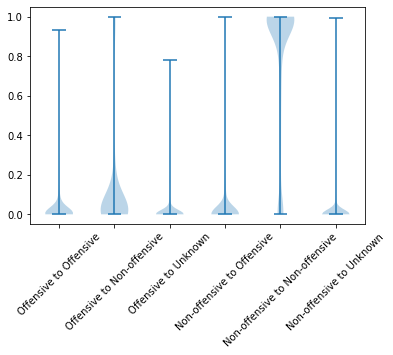

In [115]:
# Sum of attention weights to previous utterances for offensive, non-offensive and unknown
test_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'Y']
test_non_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'N']

attention_o_o = np.sum(np.array(attention_weights)[test_offensive_indices][:, 0, :][:, :10] * offensive_mask[test_offensive_indices, :], axis=1)
attention_o_n = np.sum(np.array(attention_weights)[test_offensive_indices][:, 0, :][:, :10] * non_offensive_mask[test_offensive_indices, :], axis=1)
attention_o_u = np.sum(np.array(attention_weights)[test_offensive_indices][:, 0, :][:, :10] * unknown_mask[test_offensive_indices, :], axis=1)
attention_n_o = np.sum(np.array(attention_weights)[test_non_offensive_indices][:, 0, :][:, :10] * offensive_mask[test_non_offensive_indices, :], axis=1)
attention_n_n = np.sum(np.array(attention_weights)[test_non_offensive_indices][:, 0, :][:, :10] * non_offensive_mask[test_non_offensive_indices, :], axis=1)
attention_n_u = np.sum(np.array(attention_weights)[test_non_offensive_indices][:, 0, :][:, :10] * unknown_mask[test_non_offensive_indices, :], axis=1)

# Plot violin plot
plt.violinplot([attention_o_o, attention_o_n, attention_o_u, attention_n_o, attention_n_n, attention_n_u])
plt.xticks([1, 2, 3, 4, 5, 6], ['Offensive to Offensive', 'Offensive to Non-offensive', 'Offensive to Unknown', 'Non-offensive to Offensive', 'Non-offensive to Non-offensive', 'Non-offensive to Unknown'])
plt.xticks(rotation=45)
plt.show()

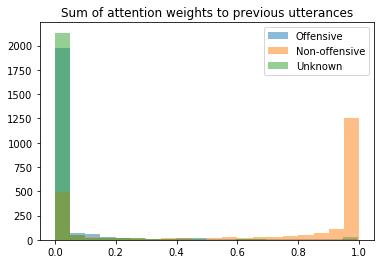

In [93]:
# Plot histogram
plt.hist(offensive_attention, bins=20, alpha=0.5, label='Offensive')
plt.hist(non_offensive_attention, bins=20, alpha=0.5, label='Non-offensive')
plt.hist(unknown_attention, bins=20, alpha=0.5, label='Unknown')
plt.legend(loc='upper right')
plt.title('Sum of attention weights to previous utterances')
plt.show()

# Use Q/A (SEP+Q)

In [85]:
# Get train data as lists
train_previous_utterance = train_data['previous_utterance'].tolist()
train_text = train_data['text'].tolist()
train_label = train_data['label'].tolist()

assert len(train_previous_utterance) == len(train_text) == len(train_label)

for i in range(len(train_previous_utterance)):
    # Remove the last utterance from the previous utterances
    train_previous_utterance[i] = train_previous_utterance[i][:-1]

    # Append speaker tags to the previous utterances
    for j in range(len(train_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(train_previous_utterance[i]) - j) % 2 == 0 else 'Q: '
        train_previous_utterance[i][j] = speaker_tag + train_previous_utterance[i][j]
    
    # Append speaker tags to the current utterance
    speaker_tag = 'A: '
    train_text[i] = speaker_tag + train_text[i]

train_full_dialog = []
for i in range(len(train_previous_utterance)):
    dialog = ''
    for j in range(len(train_previous_utterance[i])):
        dialog += train_previous_utterance[i][j] + '[SEP]'
    dialog += '[SEP]' + train_text[i]
    train_full_dialog.append(dialog)

KeyError: 'label'

In [56]:
# Get Sentence-BERT representations of each previous utterances
train_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    train_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/8955 [00:00<?, ?it/s]

In [57]:
# To Tensor
for i in range(len(train_previous_utterance_representations)):
    for j in range(len(train_previous_utterance_representations[i])):
        train_previous_utterance_representations[i][j] = torch.tensor(train_previous_utterance_representations[i][j])

In [58]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [59]:
train_dataset = DialogDataset(
    full_dialog=train_full_dialog,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [60]:
# Do the same for the test data
train_previous_utterance = test_data['previous_utterance'].tolist()
test_text = test_data['text'].tolist()
test_label = test_data['label'].tolist()

assert len(train_previous_utterance) == len(test_text) == len(test_label)

for i in range(len(train_previous_utterance)):
    train_previous_utterance[i] = train_previous_utterance[i][:-1]
    for j in range(len(train_previous_utterance[i])):
        speaker_tag = 'A: ' if (len(train_previous_utterance[i]) - j) % 2 == 0 else 'Q: '
        train_previous_utterance[i][j] = speaker_tag + train_previous_utterance[i][j]
    speaker_tag = 'A: '
    test_text[i] = speaker_tag + test_text[i]

test_full_dialog = []
for i in range(len(train_previous_utterance)):
    dialog = ''
    for j in range(len(train_previous_utterance[i])):
        dialog += train_previous_utterance[i][j] + '[SEP]'
    dialog += '[SEP]' + test_text[i]
    test_full_dialog.append(dialog)

In [61]:
test_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    test_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/2316 [00:00<?, ?it/s]

In [62]:
# To Tensor
for i in range(len(test_previous_utterance_representations)):
    for j in range(len(test_previous_utterance_representations[i])):
        test_previous_utterance_representations[i][j] = torch.tensor(test_previous_utterance_representations[i][j])

In [63]:
test_dataset = DialogDataset(
    full_dialog=test_full_dialog,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [64]:
# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [1]:
# Create the model
bert = AutoModel.from_pretrained('bert-base-uncased')

model = DialogRetrievalModel(bert, 768, 768, dropout=0.1)
model = model.cuda()

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create the scheduler
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Create the loss function
loss_fn = CrossEntropyLoss()

NameError: name 'AutoModel' is not defined

In [68]:
# Train the model
history = defaultdict(list)
best_accuracy = 0
device = 'cuda'
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
----------
Train loss 0.34865613067522644 accuracy 0.8681183696259073
Test loss 0.22980547045068495 accuracy 0.9278929188255612

Epoch 2/5
----------
Train loss 0.2062112478198417 accuracy 0.9372417643774428
Test loss 0.22514764900672538 accuracy 0.9395509499136442

Epoch 3/5
----------
Train loss 0.13857763754245492 accuracy 0.9614740368509213
Test loss 0.24942992617504606 accuracy 0.9443005181347149

Epoch 4/5
----------
Train loss 0.09992070361726552 accuracy 0.975321049692909
Test loss 0.2502836609275305 accuracy 0.9430051813471502

Epoch 5/5
----------
Train loss 0.06295914968234553 accuracy 0.9845896147403684
Test loss 0.268739466253941 accuracy 0.9434369602763385



## Results

In [69]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


In [70]:
# Classification report

# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')

print()
print(f'True-postive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]))}')
print(f'False-positive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1]))}')
print(f'False-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0]))}')
print(f'True-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]))}')

print()
print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']

print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"TP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 1])}")
print(f"FP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 1])}")
print(f"FN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 0])}")
print(f"TN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 0])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9434369602763385
Precision: 0.7928994082840237
Recall: 0.8145896656534954
F1: 0.8035982008995503

True-postive: 268
False-positive: 70
False-negative: 61
True-negative: 1917

Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.7222222222222222
TP: 52
FP: 0
FN: 20
TN: 0
Precision: 1.0
Recall: 0.7222222222222222
F1: 0.8387096774193548


# Use additional layer (SEP+A), Use no previous context in BERT encoder

In [40]:
print(len(train_text))
print(len(train_label))

8955
8955


In [135]:
# Get Sentence-BERT representations of each previous utterances
train_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    train_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/8955 [00:00<?, ?it/s]

In [136]:
# To Tensor
for i in range(len(train_previous_utterance_representations)):
    for j in range(len(train_previous_utterance_representations[i])):
        train_previous_utterance_representations[i][j] = torch.tensor(train_previous_utterance_representations[i][j])

In [137]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [138]:
train_dataset = DialogDataset(
    full_dialog=train_text,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [139]:
test_previous_utterance_representations = []
for i in tqdm(range(len(test_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(test_previous_utterance[i])):
        if test_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[test_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(test_previous_utterance[i][j]))
            sentence_bert_dict[test_previous_utterance[i][j]] = sentence_bert.encode(test_previous_utterance[i][j])
    test_previous_utterance_representations.append(previous_utterance_representations)

  0%|          | 0/2316 [00:00<?, ?it/s]

In [140]:
# To Tensor
for i in range(len(test_previous_utterance_representations)):
    for j in range(len(test_previous_utterance_representations[i])):
        test_previous_utterance_representations[i][j] = torch.tensor(test_previous_utterance_representations[i][j])

In [141]:
test_dataset = DialogDataset(
    full_dialog=test_text,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [142]:
# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [143]:
# Create the model
bert = AutoModel.from_pretrained('bert-base-uncased')

model = DialogRetrievalModel2(bert, 768, 768, dropout=0.1)
model = model.cuda()

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create the scheduler
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Create the loss function
loss_fn = CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will 

In [144]:

device = 'cuda'

In [145]:
# Train the model
history = defaultdict(list)
best_accuracy = 0
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.23351913538561866 accuracy 0.9289782244556114
Test loss 0.15777190612821743 accuracy 0.9563903281519861

Epoch 2/10
----------
Train loss 0.1210916268726578 accuracy 0.9680625348967057
Test loss 0.18949022936024543 accuracy 0.9490500863557858

Epoch 3/10
----------
Train loss 0.07354600987164303 accuracy 0.9804578447794527
Test loss 0.16492348897535802 accuracy 0.9654576856649395

Epoch 4/10
----------
Train loss 0.04876676879658979 accuracy 0.9878280290340592
Test loss 0.20848514346389807 accuracy 0.9620034542314334

Epoch 5/10
----------
Train loss 0.03834382737438448 accuracy 0.9903964265773311
Test loss 0.1902086319297488 accuracy 0.9676165803108808

Epoch 6/10
----------
Train loss 0.027471548969047684 accuracy 0.9931881630374092
Test loss 0.19901348256861293 accuracy 0.966321243523316

Epoch 7/10
----------
Train loss 0.019374519690518354 accuracy 0.9955332216638749
Test loss 0.2066866325076011 accuracy 0.964594127806563

Epoch 8/10
----------
T

## Results

In [146]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


In [147]:
# Classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')

print()
print(f'True-postive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]))}')
print(f'False-positive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1]))}')
print(f'False-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0]))}')
print(f'True-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]))}')

print()
print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']

print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"TP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 1])}")
print(f"FP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 1])}")
print(f"FN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 0])}")
print(f"TN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 0])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

# F1-score excluding the context_dependent == 'N'
indices = [i for i, x in enumerate(test_data.context_dependent) if (x == 'Y') or (y_true[i] == 0)]
print()
print("Evaluation metrics excluding those context_dependent == 'N'")
print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9676165803108808
Precision: 0.8735294117647059
Recall: 0.9027355623100304
F1: 0.8878923766816142

True-postive: 297
False-positive: 43
False-negative: 32
True-negative: 1944

Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.7361111111111112
TP: 53
FP: 0
FN: 19
TN: 0
Precision: 1.0
Recall: 0.7361111111111112
F1: 0.8480000000000001

Evaluation metrics excluding those context_dependent == 'N'
True : False = 72 : 1987
F1: 0.6309523809523809


## Analysis

In [148]:
# Save attention weights for each test set items
attention_weights = []
for index in tqdm(range(len(test_dataset))):
    bert_output = model.bert_model(input_ids=(test_dataset[index]['input_ids']).unsqueeze(0).to(device),
    attention_mask=(test_dataset[index]['attention_mask']).unsqueeze(0).to(device))
    bert_output = bert_output[1] # [CLS] representation, shape: (batch_size, bert_hidden_size)

    # Trainable layer between the BERT and attention layer
    bert_output_transformed = model.bert_output_transform(bert_output)

    # Get the attention weights
    # bert_output_transformed.unsqueeze(2) -> (batch_size, bert_hidden_size, 1)
    attention = torch.bmm((test_dataset[index]['previous_utterance_representations']).unsqueeze(0).to(device),
                            bert_output_transformed.unsqueeze(2)).squeeze(2)
    attention = torch.softmax(attention, dim=1)
    attention_weights.append(attention.cpu().detach().numpy())

  0%|          | 0/2316 [00:00<?, ?it/s]

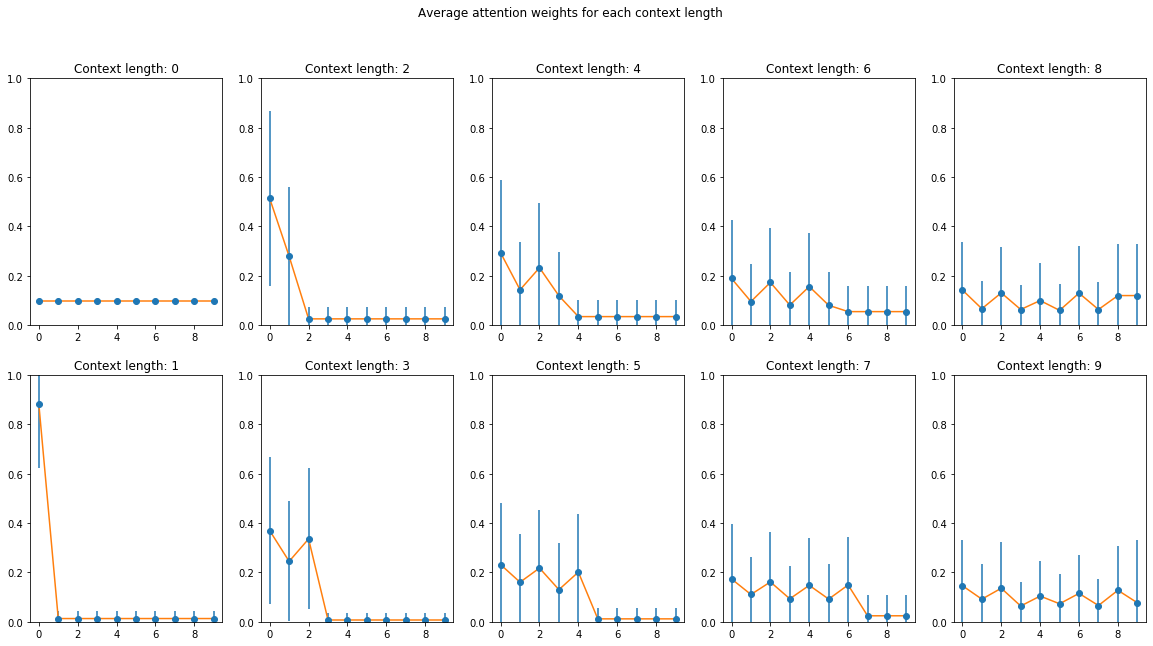

In [150]:
# plot line graph with error bar together
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Average attention weights for each context length')
for i in range(5):
    for j in range(2):
        indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i*2+j]
        average_attention_weights = np.mean(np.array(attention_weights)[indices], axis=0)
        axs[j, i].errorbar(range(len(average_attention_weights[0])), average_attention_weights[0], yerr=np.std(np.array(attention_weights)[indices], axis=0)[0], fmt='o')
        axs[j, i].plot(average_attention_weights[0])
        axs[j, i].set_title(f'Context length: {i*2+j}')
        # fix the y axis between 0 and 1
        axs[j, i].set_ylim([0, 1])
plt.show()


In [151]:
# Gather sum of attention of dependently offensive language
attention_dep_list = []
for i in range(1, 10):
    # indices of previous_utterance length = i and context_dependent = 'Y'
    indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i and test_data['context_dependent'].iloc[k] == 'Y']
    attention_dimension = list(range(i))
    result = np.sum(np.array(attention_weights)[indices][:, 0, :][:, attention_dimension], axis=1)
    attention_dep_list.append(result)

In [152]:
# Gather sum of attention of independently offensive language
attention_ind_list = []
for i in range(1, 10):
    # indices of previous_utterance length = i and context_dependent = 'Y'
    indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i and
                test_data['context_dependent'].iloc[k] == 'N' and
                test_data['offensive'].iloc[k] == 'Y']
    attention_dimension = list(range(i))
    result = np.sum(np.array(attention_weights)[indices][:, 0, :][:, attention_dimension], axis=1)
    attention_ind_list.append(result)

In [153]:
# merge attention_dep_list
attention_dep = np.concatenate(attention_dep_list)
attention_ind = np.concatenate(attention_ind_list)

Text(0.5, 1.0, 'Sum of attention weights to previous utterances (Density)')

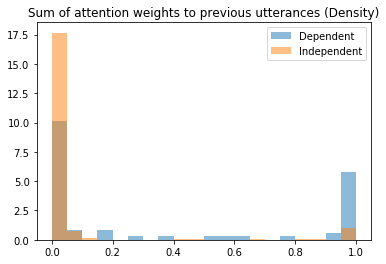

In [154]:
# Plot percentage of each bin
plt.hist(attention_dep, bins=20, alpha=0.5, label='Dependent', density=True)
plt.hist(attention_ind, bins=20, alpha=0.5, label='Independent', density=True)
plt.legend(loc='upper right')
plt.title('Sum of attention weights to previous utterances (Density)')

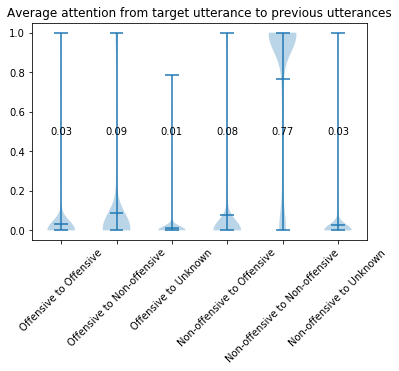

In [162]:
# Sum of attention weights to previous utterances for offensive, non-offensive and unknown
test_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'Y']
test_non_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'N']

attention_o_o = np.sum(np.array(attention_weights)[test_offensive_indices][:, 0, :][:, :10] * offensive_mask[test_offensive_indices, :], axis=1)
attention_o_n = np.sum(np.array(attention_weights)[test_offensive_indices][:, 0, :][:, :10] * non_offensive_mask[test_offensive_indices, :], axis=1)
attention_o_u = np.sum(np.array(attention_weights)[test_offensive_indices][:, 0, :][:, :10] * unknown_mask[test_offensive_indices, :], axis=1)
attention_n_o = np.sum(np.array(attention_weights)[test_non_offensive_indices][:, 0, :][:, :10] * offensive_mask[test_non_offensive_indices, :], axis=1)
attention_n_n = np.sum(np.array(attention_weights)[test_non_offensive_indices][:, 0, :][:, :10] * non_offensive_mask[test_non_offensive_indices, :], axis=1)
attention_n_u = np.sum(np.array(attention_weights)[test_non_offensive_indices][:, 0, :][:, :10] * unknown_mask[test_non_offensive_indices, :], axis=1)

# Plot violin plot
plt.violinplot([attention_o_o, attention_o_n, attention_o_u, attention_n_o, attention_n_n, attention_n_u], showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6], ['Offensive to Offensive', 'Offensive to Non-offensive', 'Offensive to Unknown', 'Non-offensive to Offensive', 'Non-offensive to Non-offensive', 'Non-offensive to Unknown'])
plt.xticks(rotation=45)
# average as a text
plt.text(1, 0.5, f'{np.mean(attention_o_o):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(2, 0.5, f'{np.mean(attention_o_n):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(3, 0.5, f'{np.mean(attention_o_u):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(4, 0.5, f'{np.mean(attention_n_o):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(5, 0.5, f'{np.mean(attention_n_n):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(6, 0.5, f'{np.mean(attention_n_u):.2f}', horizontalalignment='center', verticalalignment='center')
plt.title('Average attention from target utterance to previous utterances')
plt.show()

In [163]:
test_contextually_offensive_indices = [k for k, x in enumerate(test_data['context_dependent']) if x == 'Y']

In [164]:
len(test_contextually_offensive_indices)

72

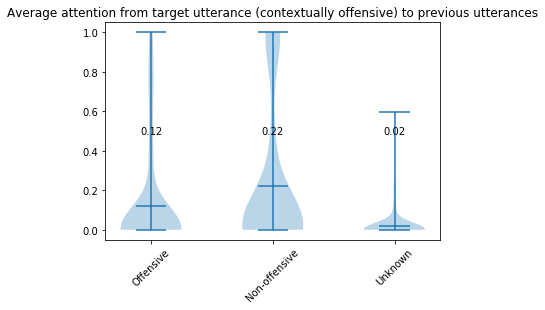

In [166]:
attention_co_o = np.sum(np.array(attention_weights)[test_contextually_offensive_indices][:, 0, :][:, :10] * offensive_mask[test_contextually_offensive_indices, :], axis=1)
attention_co_n = np.sum(np.array(attention_weights)[test_contextually_offensive_indices][:, 0, :][:, :10] * non_offensive_mask[test_contextually_offensive_indices, :], axis=1)
attention_co_u = np.sum(np.array(attention_weights)[test_contextually_offensive_indices][:, 0, :][:, :10] * unknown_mask[test_contextually_offensive_indices, :], axis=1)

plt.violinplot([attention_co_o, attention_co_n, attention_co_u], showmeans=True)
plt.xticks([1, 2, 3], ['Offensive', 'Non-offensive', 'Unknown'])
plt.xticks(rotation=45)
plt.text(1, 0.5, f'{np.mean(attention_co_o):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(2, 0.5, f'{np.mean(attention_co_n):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(3, 0.5, f'{np.mean(attention_co_u):.2f}', horizontalalignment='center', verticalalignment='center')
plt.title('Average attention from target utterance (contextually offensive) to previous utterances')
plt.show()

In [168]:
# Sum of attention weights to previous utterances for offensive, non-offensive and unknown, based on the model prediction


Number of true positives: 297
Number of true negatives: 1944
Number of false positives: 43
Number of false negatives: 32


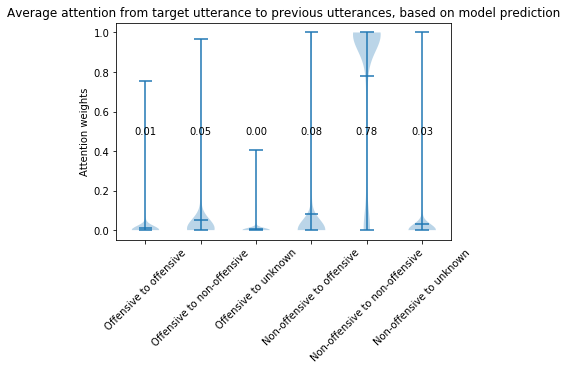

In [178]:
# Sum of attention weights to previous utterances for offensive, non-offensive and unknown
# when the model prediction is correct
test_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'Y']
test_non_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'N']

test_prediction_tp = [k for k, x in enumerate(y_pred) if (x, test_data['offensive'].iloc[k]) == (1, 'Y')]
test_prediction_tn = [k for k, x in enumerate(y_pred) if (x, test_data['offensive'].iloc[k]) == (0, 'N')]
test_prediction_fp = [k for k, x in enumerate(y_pred) if (x, test_data['offensive'].iloc[k]) == (1, 'N')]
test_prediction_fn = [k for k, x in enumerate(y_pred) if (x, test_data['offensive'].iloc[k]) == (0, 'Y')]
print(f'Number of true positives: {len(test_prediction_tp)}')
print(f'Number of true negatives: {len(test_prediction_tn)}')
print(f'Number of false positives: {len(test_prediction_fp)}')
print(f'Number of false negatives: {len(test_prediction_fn)}')

# Sum of attention weights to previous utterances for offensive, non-offensive and unknown
# based on the model prediction
attention_tp_o = np.sum(np.array(attention_weights)[test_prediction_tp][:, 0, :][:, :10] * offensive_mask[test_prediction_tp, :], axis=1)
attention_tp_n = np.sum(np.array(attention_weights)[test_prediction_tp][:, 0, :][:, :10] * non_offensive_mask[test_prediction_tp, :], axis=1)
attention_tp_u = np.sum(np.array(attention_weights)[test_prediction_tp][:, 0, :][:, :10] * unknown_mask[test_prediction_tp, :], axis=1)

attention_tn_o = np.sum(np.array(attention_weights)[test_prediction_tn][:, 0, :][:, :10] * offensive_mask[test_prediction_tn, :], axis=1)
attention_tn_n = np.sum(np.array(attention_weights)[test_prediction_tn][:, 0, :][:, :10] * non_offensive_mask[test_prediction_tn, :], axis=1)
attention_tn_u = np.sum(np.array(attention_weights)[test_prediction_tn][:, 0, :][:, :10] * unknown_mask[test_prediction_tn, :], axis=1)

attention_fp_o = np.sum(np.array(attention_weights)[test_prediction_fp][:, 0, :][:, :10] * offensive_mask[test_prediction_fp, :], axis=1)
attention_fp_n = np.sum(np.array(attention_weights)[test_prediction_fp][:, 0, :][:, :10] * non_offensive_mask[test_prediction_fp, :], axis=1)
attention_fp_u = np.sum(np.array(attention_weights)[test_prediction_fp][:, 0, :][:, :10] * unknown_mask[test_prediction_fp, :], axis=1)

attention_fn_o = np.sum(np.array(attention_weights)[test_prediction_fn][:, 0, :][:, :10] * offensive_mask[test_prediction_fn, :], axis=1)
attention_fn_n = np.sum(np.array(attention_weights)[test_prediction_fn][:, 0, :][:, :10] * non_offensive_mask[test_prediction_fn, :], axis=1)
attention_fn_u = np.sum(np.array(attention_weights)[test_prediction_fn][:, 0, :][:, :10] * unknown_mask[test_prediction_fn, :], axis=1)

# Plot violin plot
plt.violinplot([np.concatenate((attention_tp_o, attention_fp_o)), np.concatenate((attention_tp_n, attention_fp_n)), np.concatenate((attention_tp_u, attention_fp_u)),
                np.concatenate((attention_fn_o, attention_tn_o)), np.concatenate((attention_fn_n, attention_tn_n)), np.concatenate((attention_fn_u, attention_tn_u))],
                showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6], ['Offensive to offensive', 'Offensive to non-offensive', 'Offensive to unknown',
                                'Non-offensive to offensive', 'Non-offensive to non-offensive', 'Non-offensive to unknown'])
plt.xticks(rotation=45)
plt.ylabel('Attention weights')
plt.title('Average attention from target utterance to previous utterances, based on model prediction')
plt.show()

In [187]:
print()

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


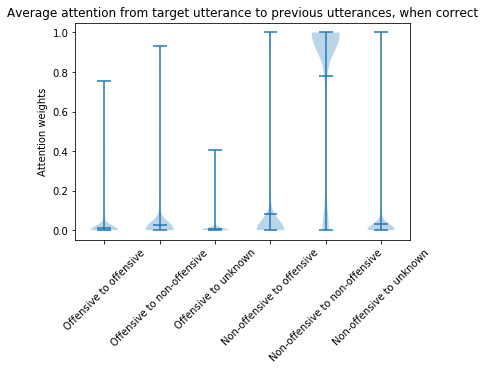

In [188]:
# Plot violin plot, only true
plt.violinplot([attention_tp_o, attention_tp_n, attention_tp_u, attention_tn_o, attention_tn_n, attention_tn_u], showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6], ['Offensive to offensive', 'Offensive to non-offensive', 'Offensive to unknown',
                                'Non-offensive to offensive', 'Non-offensive to non-offensive', 'Non-offensive to unknown'])
plt.xticks(rotation=45)
# average

plt.ylabel('Attention weights')
plt.title('Average attention from target utterance to previous utterances, when correct')
plt.show()

In [185]:
del test_data['attention_weights']

In [186]:
# save test data with prediction and attention weights
test_data['prediction'] = y_pred
test_data['argmax_attention'] = np.argmax(np.array(attention_weights)[:, 0, :][:, :10], axis=1)
test_data.to_csv('test_data_not_full_dialog_input.csv', index=False, sep=';', encoding='utf-8', float_format='%.3f')

In [184]:
test_data['argmax_attention']

id
26330000    0
26330000    0
26330000    0
26330000    1
26330000    3
           ..
7730000     3
7730000     3
7730000     6
7730000     7
7730000     6
Name: argmax_attention, Length: 2316, dtype: int64

# Use same encoder, additional layer (SEP+A)

In [63]:
encoder_name = 'sentence-transformers/all-mpnet-base-v2'

In [64]:
tokenizer = AutoTokenizer.from_pretrained(encoder_name)

In [65]:
train_dataset = DialogDataset(
    full_dialog=train_full_dialog,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [66]:
test_dataset = DialogDataset(
    full_dialog=test_full_dialog,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [67]:
# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [68]:
# Create the model
bert = AutoModel.from_pretrained(encoder_name)

model = DialogRetrievalModel2(bert, 768, 768, dropout=0.1)
model = model.cuda()

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create the scheduler
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Create the loss function
loss_fn = CrossEntropyLoss()

/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [69]:

device = 'cuda'

In [70]:
# import defaultdict
from collections import defaultdict

In [37]:
# Train the model
history = defaultdict(list)
best_accuracy = 0
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4
----------
Train loss 0.2034991698589043 accuracy 0.9355667225013958
Test loss 0.13026359805773044 accuracy 0.9615716753022452

Epoch 2/4
----------
Train loss 0.07658795510901005 accuracy 0.9797878280290341
Test loss 0.11068397162096767 accuracy 0.9715025906735751

Epoch 3/4
----------
Train loss 0.0409613347631031 accuracy 0.9900614182021217
Test loss 0.13511636694973528 accuracy 0.969775474956822

Epoch 4/4
----------
Train loss 0.021270860611964183 accuracy 0.9945281965382468
Test loss 0.15132145859574064 accuracy 0.9689119170984456



## Results

In [38]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


In [39]:
# Classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')

print()
print(f'True-postive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]))}')
print(f'False-positive: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1]))}')
print(f'False-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0]))}')
print(f'True-negative: {(sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]))}')

print()
print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']

print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"TP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 1])}")
print(f"FP: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 1])}")
print(f"FN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 1 and np.array(y_pred)[indices][i] == 0])}")
print(f"TN: {sum([1 for i in range(len(np.array(y_true)[indices])) if np.array(y_true)[indices][i] == 0 and np.array(y_pred)[indices][i] == 0])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

# F1-score excluding the context_dependent == 'N'
indices = [i for i, x in enumerate(test_data.context_dependent) if (x == 'Y') or (y_true[i] == 0)]
print()
print("Evaluation metrics excluding those context_dependent == 'N'")
print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"F1: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9689119170984456
Precision: 0.8768328445747801
Recall: 0.9088145896656535
F1: 0.8925373134328358

True-postive: 299
False-positive: 42
False-negative: 30
True-negative: 1945

Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.7916666666666666
TP: 57
FP: 0
FN: 15
TN: 0
Precision: 1.0
Recall: 0.7916666666666666
F1: 0.8837209302325582

Evaluation metrics excluding those context_dependent == 'N'
True : False = 72 : 1987
F1: 0.6666666666666667


In [64]:
torch.save(model.state_dict(), 'RetrievalModel2_epoch4_mpnetall_mpnetall')

In [65]:
del model
torch.cuda.empty_cache()

## Repeat

In [71]:
# Train the model
test_f1_scores_mpnetall = []
test_roc_auc_scores_mpnetall = []
test_dep_f1_scores_mpnetall = []
for i in range(5):
    history = defaultdict(list)
    best_accuracy = 0
    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)
        train_acc, train_loss = train(
            model,
            train_dataloader,
            loss_fn,
            optimizer,
            scheduler,
            device,
            len(train_dataset)
        )
        print(f'Train loss {train_loss} accuracy {train_acc}')
        test_acc, test_loss = evaluate(
            model,
            test_dataloader,
            loss_fn,
            device,
            len(test_dataset)
        )
        print(f'Test loss {test_loss} accuracy {test_acc}')
        print()
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_loss)

    y_true = []
    y_pred = []
    y_pred_prob = []
    model.eval()
    for d in test_dataloader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        previous_utterance_representations = d['previous_utterance_representations'].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                previous_utterance_representations=previous_utterance_representations
            )

        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        y_pred_prob.extend(np.exp(outputs[:, 1].detach().cpu().numpy()) / (np.exp(outputs[:, 1].detach().cpu().numpy()) + np.exp(outputs[:, 0].detach().cpu().numpy())))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_prob = np.array(y_pred_prob)

    test_f1_scores_mpnetall.append(f1_score(y_true, y_pred))
    test_roc_auc_scores_mpnetall.append(roc_auc_score(y_true, y_pred_prob))
    test_dep_f1_scores_mpnetall.append(f1_score(y_true[dep_test_data_index], y_pred[dep_test_data_index]))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.1924114834375879 accuracy 0.9388051367950865
Test loss 0.15489827838951142 accuracy 0.9563903281519861

Epoch 2/10
----------
Train loss 0.08002634752733034 accuracy 0.9790061418202122
Test loss 0.15664821545079607 accuracy 0.9602763385146804

Epoch 3/10
----------
Train loss 0.04938462493810221 accuracy 0.9876046901172529
Test loss 0.15714787208145997 accuracy 0.9693436960276338

Epoch 4/10
----------
Train loss 0.02823195684192927 accuracy 0.9931881630374092
Test loss 0.1637630330278249 accuracy 0.9684801381692573

Epoch 5/10
----------
Train loss 0.017197113497656704 accuracy 0.9959798994974874
Test loss 0.16428877249197504 accuracy 0.9736614853195164

Epoch 6/10
----------
Train loss 0.010999374726335581 accuracy 0.997431602456728
Test loss 0.20228418032523318 accuracy 0.9710708117443868

Epoch 7/10
----------
Train loss 0.0062699233686154396 accuracy 0.9985482970407593
Test loss 0.22464870051561117 accuracy 0.9710708117443868

Epoch 8/10
--------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.0013254085540730946 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 2/10
----------
Train loss 0.0009153243816919192 accuracy 0.9997766610831937
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 3/10
----------
Train loss 0.001422006015738069 accuracy 0.9995533221663875
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 4/10
----------
Train loss 0.002397666778506391 accuracy 0.9995533221663875
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 5/10
----------
Train loss 0.0005410489525924536 accuracy 0.9998883305415969
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 6/10
----------
Train loss 0.0003706893550120835 accuracy 0.9998883305415969
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 7/10
----------
Train loss 0.0016622651609980363 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 8/

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.0002951842145323878 accuracy 0.9998883305415969
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 2/10
----------
Train loss 0.0003499424082747282 accuracy 0.9998883305415969
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 3/10
----------
Train loss 0.0017796348876605147 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 4/10
----------
Train loss 0.00042399009145940777 accuracy 0.9998883305415969
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 5/10
----------
Train loss 0.0016984903093933618 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 6/10
----------
Train loss 0.0024528571743433402 accuracy 0.9994416527079844
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 7/10
----------
Train loss 0.0004158979871655382 accuracy 0.9998883305415969
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.0004141341499819516 accuracy 0.9998883305415969
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 2/10
----------
Train loss 0.0017467431142709497 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 3/10
----------
Train loss 0.0022160079812822784 accuracy 0.9995533221663875
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 4/10
----------
Train loss 0.0006958875900441593 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 5/10
----------
Train loss 0.0008473965563163282 accuracy 0.9997766610831937
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 6/10
----------
Train loss 0.0011519117534914715 accuracy 0.9997766610831937
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 7/10
----------
Train loss 0.0014892429814478548 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.0017380618054435868 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 2/10
----------
Train loss 0.0005722800365414774 accuracy 0.9997766610831937
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 3/10
----------
Train loss 0.0013733355232943723 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 4/10
----------
Train loss 0.0010563489182069525 accuracy 0.9997766610831937
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 5/10
----------
Train loss 0.002896150025506878 accuracy 0.9994416527079844
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 6/10
----------
Train loss 0.001132123870333349 accuracy 0.9997766610831937
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 7/10
----------
Train loss 0.0020503071461722097 accuracy 0.9996649916247906
Test loss 0.24012515387102182 accuracy 0.9689119170984456

Epoch 8/

In [72]:
print(f"Test F1-score: {np.mean(test_f1_scores_mpnetall)}")
print(f"Test ROC-AUC score: {np.mean(test_roc_auc_scores_mpnetall)}")
print(f"Test F1-score on context_dependent == 'Y': {np.mean(test_dep_f1_scores_mpnetall)}")

Test F1-score: 0.8902439024390244
Test ROC-AUC score: 0.9816489552914612
Test F1-score on context_dependent == 'Y': 0.670807453416149


In [73]:
torch.save(model.state_dict(), 'RetrievalModel2_epoch10_mpnetall_mpnetall')

In [74]:
model = model.cpu()
torch.cuda.empty_cache()

## Analysis

In [40]:
# Save attention weights for each test set items
attention_weights = []
for index in tqdm(range(len(test_dataset))):
    bert_output = model.bert_model(input_ids=(test_dataset[index]['input_ids']).unsqueeze(0).to(device),
    attention_mask=(test_dataset[index]['attention_mask']).unsqueeze(0).to(device))
    bert_output = bert_output[1] # [CLS] representation, shape: (batch_size, bert_hidden_size)

    # Trainable layer between the BERT and attention layer
    bert_output_transformed = model.bert_output_transform(bert_output)

    # Get the attention weights
    # bert_output_transformed.unsqueeze(2) -> (batch_size, bert_hidden_size, 1)
    attention = torch.bmm((test_dataset[index]['previous_utterance_representations']).unsqueeze(0).to(device),
                            bert_output_transformed.unsqueeze(2)).squeeze(2)
    attention = torch.softmax(attention, dim=1)
    attention_weights.append(attention.cpu().detach().numpy())

  0%|          | 0/2316 [00:00<?, ?it/s]

In [42]:
import matplotlib.pyplot as plt

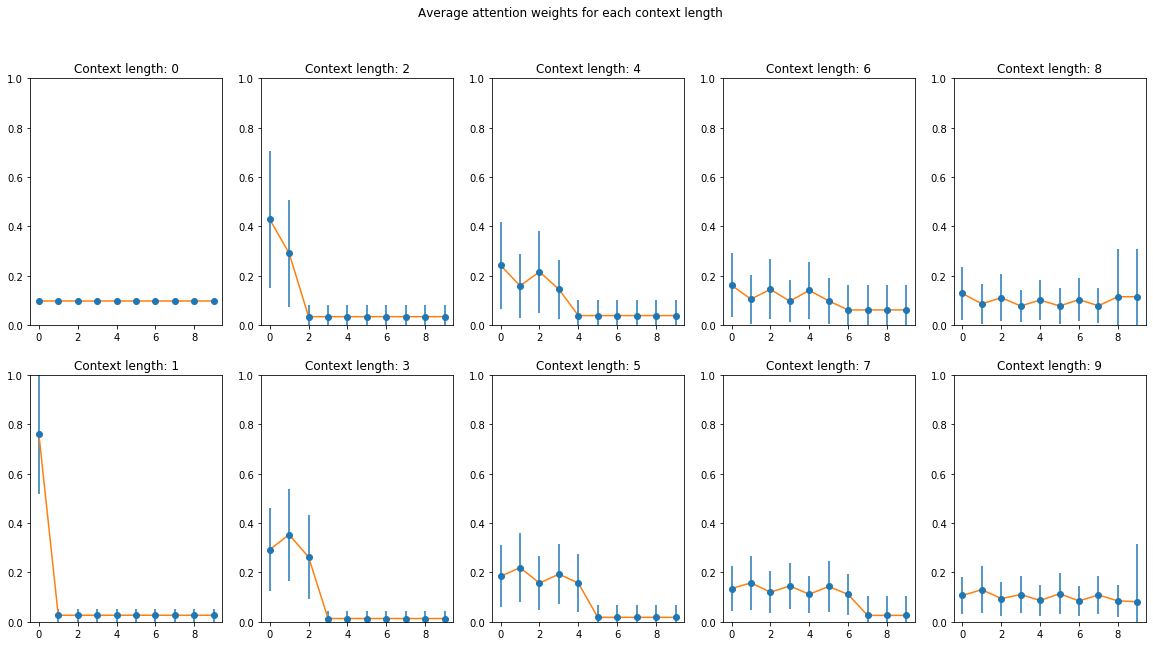

In [43]:
# plot line graph with error bar together
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Average attention weights for each context length')
for i in range(5):
    for j in range(2):
        indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i*2+j]
        average_attention_weights = np.mean(np.array(attention_weights)[indices], axis=0)
        axs[j, i].errorbar(range(len(average_attention_weights[0])), average_attention_weights[0], yerr=np.std(np.array(attention_weights)[indices], axis=0)[0], fmt='o')
        axs[j, i].plot(average_attention_weights[0])
        axs[j, i].set_title(f'Context length: {i*2+j}')
        # fix the y axis between 0 and 1
        axs[j, i].set_ylim([0, 1])
plt.show()


In [44]:
# Gather sum of attention of dependently offensive language
attention_dep_list = []
for i in range(1, 10):
    # indices of previous_utterance length = i and context_dependent = 'Y'
    indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i and test_data['context_dependent'].iloc[k] == 'Y']
    attention_dimension = list(range(i))
    result = np.sum(np.array(attention_weights)[indices][:, 0, :][:, attention_dimension], axis=1)
    attention_dep_list.append(result)

In [45]:
# Gather sum of attention of independently offensive language
attention_ind_list = []
for i in range(1, 10):
    # indices of previous_utterance length = i and context_dependent = 'Y'
    indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i and
                test_data['context_dependent'].iloc[k] == 'N' and
                test_data['offensive'].iloc[k] == 'Y']
    attention_dimension = list(range(i))
    result = np.sum(np.array(attention_weights)[indices][:, 0, :][:, attention_dimension], axis=1)
    attention_ind_list.append(result)

In [46]:
# merge attention_dep_list
attention_dep = np.concatenate(attention_dep_list)
attention_ind = np.concatenate(attention_ind_list)

Text(0.5, 1.0, 'Sum of attention weights to previous utterances (Density)')

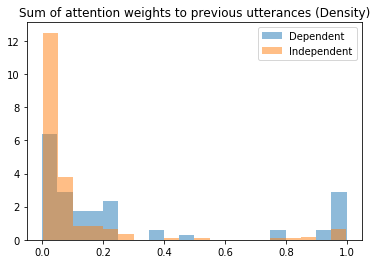

In [47]:
# Plot percentage of each bin
plt.hist(attention_dep, bins=20, alpha=0.5, label='Dependent', density=True)
plt.hist(attention_ind, bins=20, alpha=0.5, label='Independent', density=True)
plt.legend(loc='upper right')
plt.title('Sum of attention weights to previous utterances (Density)')

In [56]:
offensive_dict = {}
for session_no, message_no, offensiveness in zip(test_data['session_no'], test_data['message_no'], test_data['offensive']):
    if session_no not in offensive_dict:
        offensive_dict[session_no] = {}
    offensive_dict[session_no][message_no] = offensiveness

In [57]:
# Make three mask array, one for offensive, one for non-offensive, one for unknown
offensive_mask = np.zeros([len(test_data), 10])
non_offensive_mask = np.zeros([len(test_data), 10])
unknown_mask = np.zeros([len(test_data), 10])
for i, (session_no, message_no) in enumerate(zip(test_data['session_no'], test_data['message_no'])):
    for j in range(message_no):
        if j < len(test_previous_utterance[i]):
            if session_no in offensive_dict and j in offensive_dict[session_no]:
                if offensive_dict[session_no][j] == 'Y':
                    offensive_mask[i, j] = 1
                elif offensive_dict[session_no][j] == 'N':
                    non_offensive_mask[i, j] = 1
                else:
                    unknown_mask[i, j] = 1
            else:
                unknown_mask[i, j] = 1

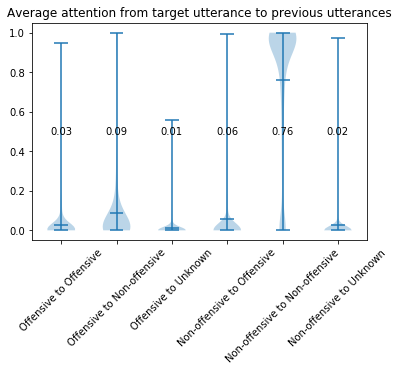

In [58]:
# Sum of attention weights to previous utterances for offensive, non-offensive and unknown
test_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'Y']
test_non_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'N']

attention_o_o = np.sum(np.array(attention_weights)[test_offensive_indices][:, 0, :][:, :10] * offensive_mask[test_offensive_indices, :], axis=1)
attention_o_n = np.sum(np.array(attention_weights)[test_offensive_indices][:, 0, :][:, :10] * non_offensive_mask[test_offensive_indices, :], axis=1)
attention_o_u = np.sum(np.array(attention_weights)[test_offensive_indices][:, 0, :][:, :10] * unknown_mask[test_offensive_indices, :], axis=1)
attention_n_o = np.sum(np.array(attention_weights)[test_non_offensive_indices][:, 0, :][:, :10] * offensive_mask[test_non_offensive_indices, :], axis=1)
attention_n_n = np.sum(np.array(attention_weights)[test_non_offensive_indices][:, 0, :][:, :10] * non_offensive_mask[test_non_offensive_indices, :], axis=1)
attention_n_u = np.sum(np.array(attention_weights)[test_non_offensive_indices][:, 0, :][:, :10] * unknown_mask[test_non_offensive_indices, :], axis=1)

# Plot violin plot
plt.violinplot([attention_o_o, attention_o_n, attention_o_u, attention_n_o, attention_n_n, attention_n_u], showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6], ['Offensive to Offensive', 'Offensive to Non-offensive', 'Offensive to Unknown', 'Non-offensive to Offensive', 'Non-offensive to Non-offensive', 'Non-offensive to Unknown'])
plt.xticks(rotation=45)
# average as a text
plt.text(1, 0.5, f'{np.mean(attention_o_o):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(2, 0.5, f'{np.mean(attention_o_n):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(3, 0.5, f'{np.mean(attention_o_u):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(4, 0.5, f'{np.mean(attention_n_o):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(5, 0.5, f'{np.mean(attention_n_n):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(6, 0.5, f'{np.mean(attention_n_u):.2f}', horizontalalignment='center', verticalalignment='center')
plt.title('Average attention from target utterance to previous utterances')
plt.show()

In [59]:
test_contextually_offensive_indices = [k for k, x in enumerate(test_data['context_dependent']) if x == 'Y']

In [60]:
len(test_contextually_offensive_indices)

72

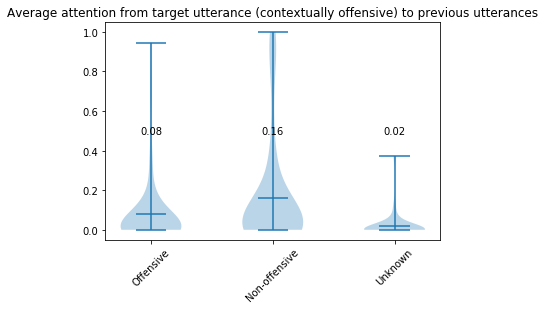

In [61]:
attention_co_o = np.sum(np.array(attention_weights)[test_contextually_offensive_indices][:, 0, :][:, :10] * offensive_mask[test_contextually_offensive_indices, :], axis=1)
attention_co_n = np.sum(np.array(attention_weights)[test_contextually_offensive_indices][:, 0, :][:, :10] * non_offensive_mask[test_contextually_offensive_indices, :], axis=1)
attention_co_u = np.sum(np.array(attention_weights)[test_contextually_offensive_indices][:, 0, :][:, :10] * unknown_mask[test_contextually_offensive_indices, :], axis=1)

plt.violinplot([attention_co_o, attention_co_n, attention_co_u], showmeans=True)
plt.xticks([1, 2, 3], ['Offensive', 'Non-offensive', 'Unknown'])
plt.xticks(rotation=45)
plt.text(1, 0.5, f'{np.mean(attention_co_o):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(2, 0.5, f'{np.mean(attention_co_n):.2f}', horizontalalignment='center', verticalalignment='center')
plt.text(3, 0.5, f'{np.mean(attention_co_u):.2f}', horizontalalignment='center', verticalalignment='center')
plt.title('Average attention from target utterance (contextually offensive) to previous utterances')
plt.show()

In [62]:
# Sum of attention weights to previous utterances for offensive, non-offensive and unknown, based on the model prediction


Number of true positives: 299
Number of true negatives: 1945
Number of false positives: 42
Number of false negatives: 30


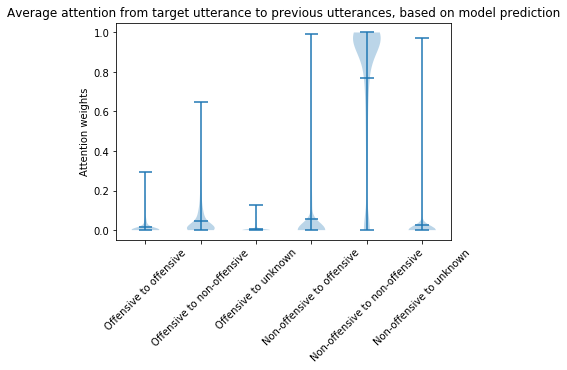

In [63]:
# Sum of attention weights to previous utterances for offensive, non-offensive and unknown
# when the model prediction is correct
test_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'Y']
test_non_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'N']

test_prediction_tp = [k for k, x in enumerate(y_pred) if (x, test_data['offensive'].iloc[k]) == (1, 'Y')]
test_prediction_tn = [k for k, x in enumerate(y_pred) if (x, test_data['offensive'].iloc[k]) == (0, 'N')]
test_prediction_fp = [k for k, x in enumerate(y_pred) if (x, test_data['offensive'].iloc[k]) == (1, 'N')]
test_prediction_fn = [k for k, x in enumerate(y_pred) if (x, test_data['offensive'].iloc[k]) == (0, 'Y')]
print(f'Number of true positives: {len(test_prediction_tp)}')
print(f'Number of true negatives: {len(test_prediction_tn)}')
print(f'Number of false positives: {len(test_prediction_fp)}')
print(f'Number of false negatives: {len(test_prediction_fn)}')

# Sum of attention weights to previous utterances for offensive, non-offensive and unknown
# based on the model prediction
attention_tp_o = np.sum(np.array(attention_weights)[test_prediction_tp][:, 0, :][:, :10] * offensive_mask[test_prediction_tp, :], axis=1)
attention_tp_n = np.sum(np.array(attention_weights)[test_prediction_tp][:, 0, :][:, :10] * non_offensive_mask[test_prediction_tp, :], axis=1)
attention_tp_u = np.sum(np.array(attention_weights)[test_prediction_tp][:, 0, :][:, :10] * unknown_mask[test_prediction_tp, :], axis=1)

attention_tn_o = np.sum(np.array(attention_weights)[test_prediction_tn][:, 0, :][:, :10] * offensive_mask[test_prediction_tn, :], axis=1)
attention_tn_n = np.sum(np.array(attention_weights)[test_prediction_tn][:, 0, :][:, :10] * non_offensive_mask[test_prediction_tn, :], axis=1)
attention_tn_u = np.sum(np.array(attention_weights)[test_prediction_tn][:, 0, :][:, :10] * unknown_mask[test_prediction_tn, :], axis=1)

attention_fp_o = np.sum(np.array(attention_weights)[test_prediction_fp][:, 0, :][:, :10] * offensive_mask[test_prediction_fp, :], axis=1)
attention_fp_n = np.sum(np.array(attention_weights)[test_prediction_fp][:, 0, :][:, :10] * non_offensive_mask[test_prediction_fp, :], axis=1)
attention_fp_u = np.sum(np.array(attention_weights)[test_prediction_fp][:, 0, :][:, :10] * unknown_mask[test_prediction_fp, :], axis=1)

attention_fn_o = np.sum(np.array(attention_weights)[test_prediction_fn][:, 0, :][:, :10] * offensive_mask[test_prediction_fn, :], axis=1)
attention_fn_n = np.sum(np.array(attention_weights)[test_prediction_fn][:, 0, :][:, :10] * non_offensive_mask[test_prediction_fn, :], axis=1)
attention_fn_u = np.sum(np.array(attention_weights)[test_prediction_fn][:, 0, :][:, :10] * unknown_mask[test_prediction_fn, :], axis=1)

# Plot violin plot
plt.violinplot([np.concatenate((attention_tp_o, attention_fp_o)), np.concatenate((attention_tp_n, attention_fp_n)), np.concatenate((attention_tp_u, attention_fp_u)),
                np.concatenate((attention_fn_o, attention_tn_o)), np.concatenate((attention_fn_n, attention_tn_n)), np.concatenate((attention_fn_u, attention_tn_u))],
                showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6], ['Offensive to offensive', 'Offensive to non-offensive', 'Offensive to unknown',
                                'Non-offensive to offensive', 'Non-offensive to non-offensive', 'Non-offensive to unknown'])
plt.xticks(rotation=45)
plt.ylabel('Attention weights')
plt.title('Average attention from target utterance to previous utterances, based on model prediction')
plt.show()

# Use same encoder, additional layer (SEP+A) (all-distilroberta-v1)

In [65]:
encoder_name = 'sentence-transformers/all-distilroberta-v1'

In [66]:
tokenizer = AutoTokenizer.from_pretrained(encoder_name)

In [67]:
encoder_name_short = encoder_name.split('/')[-1]

In [69]:
sentence_bert = SentenceTransformer(encoder_name)

In [71]:
# If 'sentence_bert_dict_all-mpnet-base-v2.pkl' exists, load it
if os.path.exists(f'sentence_bert_dict_{encoder_name_short}.pkl'):
    with open(f'sentence_bert_dict_{encoder_name_short}.pkl', 'rb') as f:
        sentence_bert_dict = pickle.load(f)
else:
    sentence_bert_dict = {}
# Get Sentence-BERT representations of each previous utterances
train_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    train_previous_utterance_representations.append(previous_utterance_representations)
# To Tensor
for i in range(len(train_previous_utterance_representations)):
    for j in range(len(train_previous_utterance_representations[i])):
        train_previous_utterance_representations[i][j] = torch.tensor(train_previous_utterance_representations[i][j])

  0%|          | 0/8955 [00:00<?, ?it/s]

In [72]:
# Save sentence_bert_dict
with open(f'sentence_bert_dict_{encoder_name_short}.pkl', 'wb') as f:
    pickle.dump(sentence_bert_dict, f)

In [73]:
# If 'sentence_bert_dict_all-mpnet-base-v2.pkl' exists, load it
if os.path.exists(f'sentence_bert_dict_{encoder_name_short}.pkl'):
    with open(f'sentence_bert_dict_{encoder_name_short}.pkl', 'rb') as f:
        sentence_bert_dict = pickle.load(f)
else:
    sentence_bert_dict = {}
# Get Sentence-BERT representations of each previous utterances
test_previous_utterance_representations = []
for i in tqdm(range(len(test_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(test_previous_utterance[i])):
        if test_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[test_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(test_previous_utterance[i][j]))
            sentence_bert_dict[test_previous_utterance[i][j]] = sentence_bert.encode(test_previous_utterance[i][j])
    test_previous_utterance_representations.append(previous_utterance_representations)
    # To Tensor
    for i in range(len(test_previous_utterance_representations)):
        for j in range(len(test_previous_utterance_representations[i])):
            test_previous_utterance_representations[i][j] = torch.tensor(test_previous_utterance_representations[i][j])

  0%|          | 0/2316 [00:00<?, ?it/s]

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [74]:
# Save sentence_bert_dict
with open(f'sentence_bert_dict_{encoder_name_short}.pkl', 'wb') as f:
    pickle.dump(sentence_bert_dict, f)

In [75]:
train_dataset = DialogDataset(
    full_dialog=train_full_dialog,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [76]:
test_dataset = DialogDataset(
    full_dialog=test_full_dialog,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [77]:
# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [78]:
# Create the model
bert = AutoModel.from_pretrained(encoder_name)

model = DialogRetrievalModel2(bert, 768, 768, dropout=0.1)
model = model.cuda()

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create the scheduler
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Create the loss function
loss_fn = CrossEntropyLoss()

/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [79]:

device = 'cuda'

In [80]:
# import defaultdict
from collections import defaultdict

In [81]:
# Train the model
history = defaultdict(list)
best_accuracy = 0
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4
----------
Train loss 0.17871306802636744 accuracy 0.9390284757118927
Test loss 0.1845692215527504 accuracy 0.9568221070811744

Epoch 2/4
----------
Train loss 0.08072543161740343 accuracy 0.9791178112786153
Test loss 0.14541369004873558 accuracy 0.9689119170984456

Epoch 3/4
----------
Train loss 0.040003140984689316 accuracy 0.9898380792853154
Test loss 0.1812276138200481 accuracy 0.9676165803108808

Epoch 4/4
----------
Train loss 0.01735097547373568 accuracy 0.9953098827470687
Test loss 0.19887340437979156 accuracy 0.9671848013816925



## Results

In [83]:
# Evaluation
# Get y_true, y_pred
y_true = []
y_pred = []
y_pred_prob = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    previous_utterance_representations = batch['previous_utterance_representations'].to(device)
    labels = batch['label'].to(device)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        previous_utterance_representations=previous_utterance_representations
    )
    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.detach().cpu().numpy())
    y_pred.extend(preds.detach().cpu().numpy())
    y_pred_prob.extend(np.exp(outputs[:, 1].detach().cpu().numpy()) / (np.exp(outputs[:, 1].detach().cpu().numpy()) + np.exp(outputs[:, 0].detach().cpu().numpy())))


In [86]:
# Show performance
print(f'test F1 score: {f1_score(y_true, y_pred)}')
print(f'test accuracy: {accuracy_score(y_true, y_pred)}')
print(f'test precision: {precision_score(y_true, y_pred)}')
print(f'test recall: {recall_score(y_true, y_pred)}')
print(f'test roc_auc_score: {roc_auc_score(y_true, y_pred_prob)}')

test F1 score: 0.8869047619047619
test accuracy: 0.9671848013816926
test precision: 0.8688046647230321
test recall: 0.9057750759878419
test roc_auc_score: 0.9860506667196963


In [92]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [93]:
print(f1_score(y_true[dep_test_data_index], y_pred[dep_test_data_index]))

0.6779661016949152


# MPNet-all, no context, yes attention

In [82]:
main_encoder_name = 'sentence-transformers/all-mpnet-base-v2'
main_encoder_name_short = main_encoder_name.split('/')[-1]
context_encoder_name = 'sentence-transformers/all-mpnet-base-v2'
context_encoder_name_short = context_encoder_name.split('/')[-1]

In [91]:
use_full_dialog = False

In [83]:
tokenizer = AutoTokenizer.from_pretrained(main_encoder_name)

In [84]:
sentence_bert = SentenceTransformer(context_encoder_name_short)

In [85]:
# If 'sentence_bert_dict_all-mpnet-base-v2.pkl' exists, load it
if os.path.exists(f'sentence_bert_dict_{context_encoder_name_short}.pkl'):
    with open(f'sentence_bert_dict_{context_encoder_name_short}.pkl', 'rb') as f:
        sentence_bert_dict = pickle.load(f)
else:
    sentence_bert_dict = {}
# Get Sentence-BERT representations of each previous utterances
train_previous_utterance_representations = []
for i in tqdm(range(len(train_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(train_previous_utterance[i])):
        if train_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[train_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(train_previous_utterance[i][j]))
            sentence_bert_dict[train_previous_utterance[i][j]] = sentence_bert.encode(train_previous_utterance[i][j])
    train_previous_utterance_representations.append(previous_utterance_representations)
# To Tensor
for i in range(len(train_previous_utterance_representations)):
    for j in range(len(train_previous_utterance_representations[i])):
        train_previous_utterance_representations[i][j] = torch.tensor(train_previous_utterance_representations[i][j])

  0%|          | 0/8955 [00:00<?, ?it/s]

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [87]:
# Save sentence_bert_dict
with open(f'sentence_bert_dict_{context_encoder_name_short}.pkl', 'wb') as f:
    pickle.dump(sentence_bert_dict, f)

In [88]:
# If 'sentence_bert_dict_all-mpnet-base-v2.pkl' exists, load it
if os.path.exists(f'sentence_bert_dict_{context_encoder_name_short}.pkl'):
    with open(f'sentence_bert_dict_{context_encoder_name_short}.pkl', 'rb') as f:
        sentence_bert_dict = pickle.load(f)
else:
    sentence_bert_dict = {}
# Get Sentence-BERT representations of each previous utterances
test_previous_utterance_representations = []
for i in tqdm(range(len(test_previous_utterance))):
    previous_utterance_representations = []
    for j in range(len(test_previous_utterance[i])):
        if test_previous_utterance[i][j] in sentence_bert_dict:
            previous_utterance_representations.append(sentence_bert_dict[test_previous_utterance[i][j]])
        else:
            previous_utterance_representations.append(sentence_bert.encode(test_previous_utterance[i][j]))
            sentence_bert_dict[test_previous_utterance[i][j]] = sentence_bert.encode(test_previous_utterance[i][j])
    test_previous_utterance_representations.append(previous_utterance_representations)
    # To Tensor
    for i in range(len(test_previous_utterance_representations)):
        for j in range(len(test_previous_utterance_representations[i])):
            test_previous_utterance_representations[i][j] = torch.tensor(test_previous_utterance_representations[i][j])

  0%|          | 0/2316 [00:00<?, ?it/s]

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [89]:
# Save sentence_bert_dict
with open(f'sentence_bert_dict_{context_encoder_name_short}.pkl', 'wb') as f:
    pickle.dump(sentence_bert_dict, f)

In [92]:
train_dataset = DialogDataset(
    full_dialog=train_full_dialog if use_full_dialog else train_text,
    previous_utterance_representations=train_previous_utterance_representations,
    label=train_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [93]:
test_dataset = DialogDataset(
    full_dialog=test_full_dialog if use_full_dialog else test_text,
    previous_utterance_representations=test_previous_utterance_representations,
    label=test_label,
    max_len=512,
    max_utterance=10,
    tokenizer=tokenizer
)

In [94]:
# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [95]:
# Create the model
bert = AutoModel.from_pretrained(main_encoder_name)

model = DialogRetrievalModel2(bert, 768, 768, dropout=0.1)
model = model.cuda()

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create the scheduler
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Create the loss function
loss_fn = CrossEntropyLoss()

/home/intern/mingi/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [96]:

device = 'cuda'

In [97]:
# import defaultdict
from collections import defaultdict

In [98]:
# Train the model
history = defaultdict(list)
best_accuracy = 0
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        device,
        len(train_dataset)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = evaluate(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(test_dataset)
    )
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.23013812981911802 accuracy 0.9257398101619206
Test loss 0.14204639331919366 accuracy 0.9568221070811744

Epoch 2/10
----------
Train loss 0.11265614716685377 accuracy 0.9677275265214963
Test loss 0.17090701029218477 accuracy 0.951208981001727

Epoch 3/10
----------
Train loss 0.08206866241692166 accuracy 0.977107761027359
Test loss 0.1683709487624081 accuracy 0.9589810017271156

Epoch 4/10
----------
Train loss 0.05280551804587178 accuracy 0.9860413176996091
Test loss 0.17284877365535317 accuracy 0.9632987910189982

Epoch 5/10
----------
Train loss 0.04226617652904159 accuracy 0.9901730876605248
Test loss 0.1884462085420041 accuracy 0.9637305699481865

Epoch 6/10
----------
Train loss 0.032352853070447704 accuracy 0.9918481295365718
Test loss 0.1946137193110691 accuracy 0.9624352331606217

Epoch 7/10
----------
Train loss 0.026471756104053515 accuracy 0.9927414852037967
Test loss 0.2041023525553916 accuracy 0.9650259067357513

Epoch 8/10
----------
Tr

### Results

In [99]:
y_true = []
y_pred = []
y_pred_prob = []
model.eval()
for d in tqdm(test_dataloader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)
    previous_utterance_representations = d['previous_utterance_representations'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            previous_utterance_representations=previous_utterance_representations
        )

    _, preds = torch.max(outputs, dim=1)
    y_true.extend(labels.detach().cpu().numpy())
    y_pred.extend(preds.detach().cpu().numpy())
    y_pred_prob.extend(np.exp(outputs[:, 1].detach().cpu().numpy()) / (np.exp(outputs[:, 1].detach().cpu().numpy()) + np.exp(outputs[:, 0].detach().cpu().numpy())))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

print(f"F1-score: {f1_score(y_true, y_pred)}")
print(f"ROC-AUC score: {roc_auc_score(y_true, y_pred_prob)}")
print(f"Dep-F1-score: {f1_score(y_true[dep_test_data_index], y_pred[dep_test_data_index])}")

  0%|          | 0/145 [00:00<?, ?it/s]

F1-score: 0.8805970149253731
ROC-AUC score: 0.9713028300977631
Dep-F1-score: 0.5952380952380953


In [209]:
# save model
torch.save(model.state_dict(), f'dialog_retrieval_model_{main_encoder_name_short}_{context_encoder_name_short}_nocontext.pt')

### Analysis

In [100]:
# Save attention weights for each test set items
attention_weights = []
for index in tqdm(range(len(test_dataset))):
    bert_output = model.bert_model(input_ids=(test_dataset[index]['input_ids']).unsqueeze(0).to(device),
    attention_mask=(test_dataset[index]['attention_mask']).unsqueeze(0).to(device))
    bert_output = bert_output[1] # [CLS] representation, shape: (batch_size, bert_hidden_size)

    # Trainable layer between the BERT and attention layer
    bert_output_transformed = model.bert_output_transform(bert_output)

    # Get the attention weights
    # bert_output_transformed.unsqueeze(2) -> (batch_size, bert_hidden_size, 1)
    attention = torch.bmm((test_dataset[index]['previous_utterance_representations']).unsqueeze(0).to(device),
                            bert_output_transformed.unsqueeze(2)).squeeze(2)
    attention = torch.softmax(attention, dim=1)
    attention_weights.append(attention.cpu().detach().numpy())

  0%|          | 0/2316 [00:00<?, ?it/s]

In [110]:
print(len(attention_weights))
print(attention_weights[0].shape)

2316
(1, 10)


In [111]:
attention_weights_array = np.array(attention_weights)

In [114]:
# remove dimension 1
attention_weights_array = np.squeeze(attention_weights_array, axis=1)

In [115]:
attention_weights_array.shape

(2316, 10)

In [116]:
attention_prev_list = []
previous_context_length = [len(x) for x in test_previous_utterance]

In [120]:
for i in range(len(test_dataset)):
    attention_prev_list.append(attention_weights_array[i, :previous_context_length[i]].sum(axis=0))

In [123]:
attention_prev = np.array(attention_prev_list)

In [101]:
# Gather sum of attention of dependently offensive language
attention_dep_list = []
for i in range(1, 10):
    # indices of previous_utterance length = i and context_dependent = 'Y'
    indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i and test_data['context_dependent'].iloc[k] == 'Y']
    attention_dimension = list(range(i))
    result = np.sum(np.array(attention_weights)[indices][:, 0, :][:, attention_dimension], axis=1)
    attention_dep_list.append(result)

In [102]:
# Gather sum of attention of independently offensive language
attention_ind_list = []
for i in range(1, 10):
    # indices of previous_utterance length = i and context_dependent = 'Y'
    indices = [k for k, x in enumerate(test_previous_utterance) if len(x) == i and
                test_data['context_dependent'].iloc[k] == 'N' and
                test_data['offensive'].iloc[k] == 'Y']
    attention_dimension = list(range(i))
    result = np.sum(np.array(attention_weights)[indices][:, 0, :][:, attention_dimension], axis=1)
    attention_ind_list.append(result)

In [103]:
# merge attention_dep_list
attention_dep = np.concatenate(attention_dep_list)
attention_ind = np.concatenate(attention_ind_list)

In [109]:
attention_dep.shape

(69,)

In [105]:
import matplotlib.pyplot as plt

In [104]:
# Plot percentage of each bin
plt.hist(attention_dep, bins=20, alpha=0.5, label='Dependent', density=True)
plt.hist(attention_ind, bins=20, alpha=0.5, label='Independent', density=True)
plt.legend(loc='upper right')
plt.title('Sum of attention weights to previous utterances (Density)')

NameError: name 'plt' is not defined

In [124]:
test_dep_offensive_indices = [k for k, x in enumerate(test_data['context_dependent']) if x == 'Y' and test_data['offensive'].iloc[k] == 'Y']
test_ind_offensive_indices = [k for k, x in enumerate(test_data['context_dependent']) if x == 'N' and test_data['offensive'].iloc[k] == 'Y']
test_non_offensive_indices = [k for k, x in enumerate(test_data['offensive']) if x == 'N']

In [125]:
print(len(test_dep_offensive_indices))
print(len(test_ind_offensive_indices))
print(len(test_non_offensive_indices))

72
257
1987


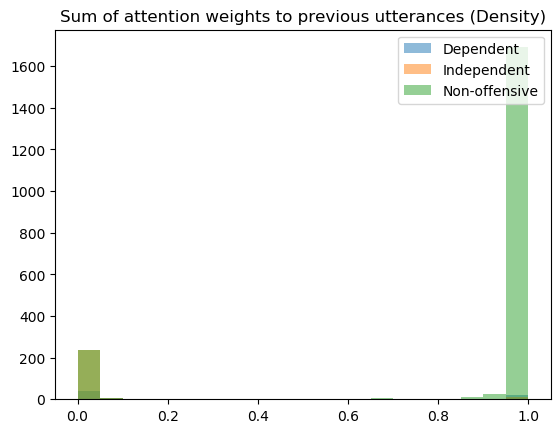

In [127]:
# Plot percentage of each bin
plt.hist(attention_prev[test_dep_offensive_indices], bins=20, alpha=0.5, label='Dependent')
plt.hist(attention_prev[test_ind_offensive_indices], bins=20, alpha=0.5, label='Independent')
plt.hist(attention_prev[test_non_offensive_indices], bins=20, alpha=0.5, label='Non-offensive')
plt.legend(loc='upper right')
plt.title('Sum of attention weights to previous utterances (Density)')
plt.show()

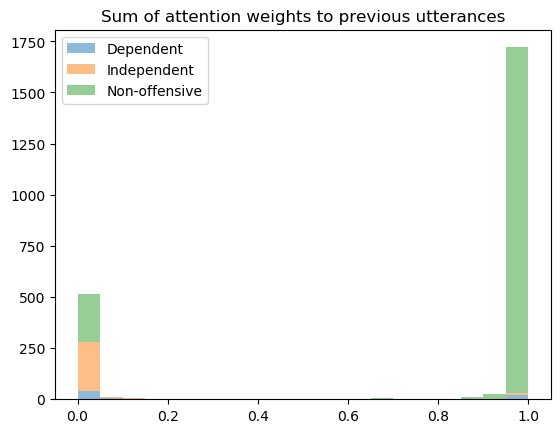

In [161]:
# Plot histogram, each set stacked on top of each other
plt.hist([attention_prev[test_dep_offensive_indices], attention_prev[test_ind_offensive_indices], attention_prev[test_non_offensive_indices]], bins=20, alpha=0.5, label=['Dependent', 'Independent', 'Non-offensive'], stacked=True)
plt.legend(loc='upper left')
plt.title('Sum of attention weights to previous utterances')
plt.show()

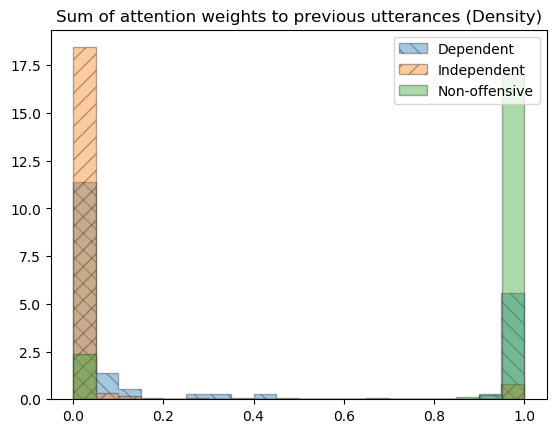

In [183]:
# Plot percentage of each bin, overlap each other
# Dependently offensive: filled with orange, with black dotted pattern
plt.hist(attention_prev[test_dep_offensive_indices], bins=20, alpha=0.4, label='Dependent', density=True, histtype='stepfilled', hatch='\\\\', edgecolor='0.2')
# Independently offensive: filled with blue, with black hatch pattern
plt.hist(attention_prev[test_ind_offensive_indices], bins=20, alpha=0.4, label='Independent', density=True, histtype='stepfilled', hatch='//', edgecolor='0.2')
# Non-offensive: filled with green, without pattern
plt.hist(attention_prev[test_non_offensive_indices], bins=20, alpha=0.4, label='Non-offensive', density=True, histtype='bar', edgecolor='0.2')
plt.legend(loc='upper right')
plt.title('Sum of attention weights to previous utterances (Density)')
plt.show()

In [184]:
# filter correctly classified data
test_true_indices = [k for k, x in enumerate(y_true) if x == y_pred[k]]
test_false_indices = [k for k, x in enumerate(y_true) if x != y_pred[k]]

In [186]:
print(len(test_true_indices))
print(len(test_false_indices))

2236
80


/home/intern/mingi/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/intern/mingi/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

<Figure size 640x480 with 0 Axes>

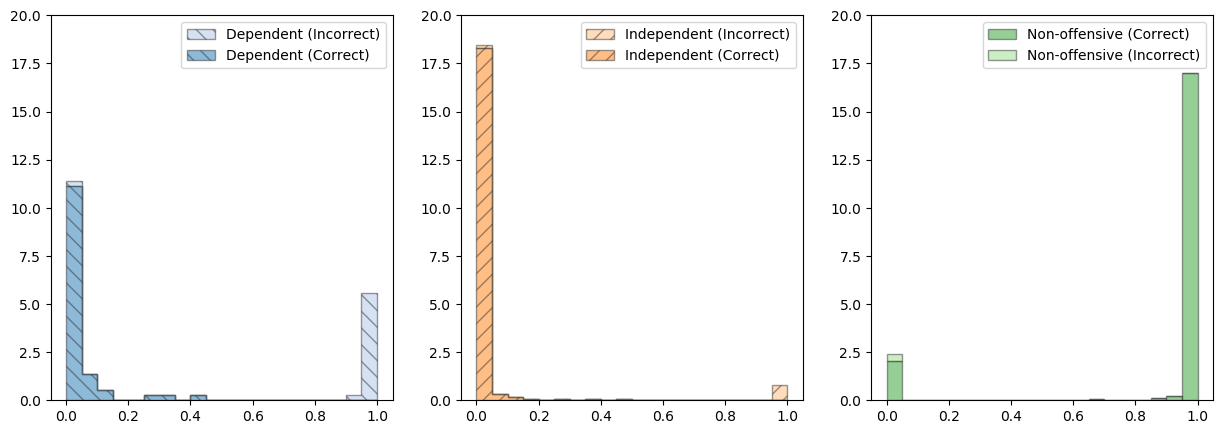

In [208]:
# Plot the same graph as above, but distinguish correctly classified and misclassified data by stacking them
# Use 3 subplots
# Use colormap tab20
plt.set_cmap('tab20')
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
kwargs = dict(alpha=0.5, density=True, bins=20, edgecolor='0.2')
plt.hist(
    [attention_prev[list(set(test_dep_offensive_indices) & set(test_true_indices))],
        attention_prev[list(set(test_dep_offensive_indices) & set(test_false_indices))]],
    label=['Dependent (Correct)', 'Dependent (Incorrect)'],
    stacked=True, histtype='stepfilled', hatch='\\\\',
    color=[plt.cm.tab20(0), plt.cm.tab20(1)], **kwargs)
plt.ylim(0, 20)
plt.legend(loc='upper right')
plt.subplot(1, 3, 2)
plt.hist(
    [attention_prev[list(set(test_ind_offensive_indices) & set(test_true_indices))],
        attention_prev[list(set(test_ind_offensive_indices) & set(test_false_indices))]],
    label=['Independent (Correct)', 'Independent (Incorrect)'],
    stacked=True, histtype='stepfilled', hatch='//',
    color=[plt.cm.tab20(2), plt.cm.tab20(3)], **kwargs)
plt.ylim(0, 20)
plt.legend(loc='upper right')
plt.subplot(1, 3, 3)
plt.hist(
    [attention_prev[list(set(test_non_offensive_indices) & set(test_true_indices))],
        attention_prev[list(set(test_non_offensive_indices) & set(test_false_indices))]],
    label=['Non-offensive (Correct)', 'Non-offensive (Incorrect)'],
    stacked=True, histtype='bar',
    color=[plt.cm.tab20(4), plt.cm.tab20(5)], **kwargs)
plt.ylim(0, 20)
plt.legend(loc='upper right')
plt.show()

In [203]:
# show pandas table of the above
df = pd.DataFrame(
    [[np.mean(attention_prev[list(set(test_dep_offensive_indices) & set(test_true_indices))]),

    np.mean(attention_prev[list(set(test_dep_offensive_indices) & set(test_false_indices))])],
    [np.mean(attention_prev[list(set(test_ind_offensive_indices) & set(test_true_indices))]),
    np.mean(attention_prev[list(set(test_ind_offensive_indices) & set(test_false_indices))])],
    [np.mean(attention_prev[list(set(test_non_offensive_indices) & set(test_true_indices))]),
    np.mean(attention_prev[list(set(test_non_offensive_indices) & set(test_false_indices))])]],
    index=['Dependent', 'Independent', 'Non-offensive'],
    columns=['Correct', 'Incorrect'])
print(df)

                Correct  Incorrect
Dependent      0.039812   0.947006
Independent    0.011721   0.829339
Non-offensive  0.888865   0.069187


# Tables & Figures

<Figure size 640x480 with 0 Axes>

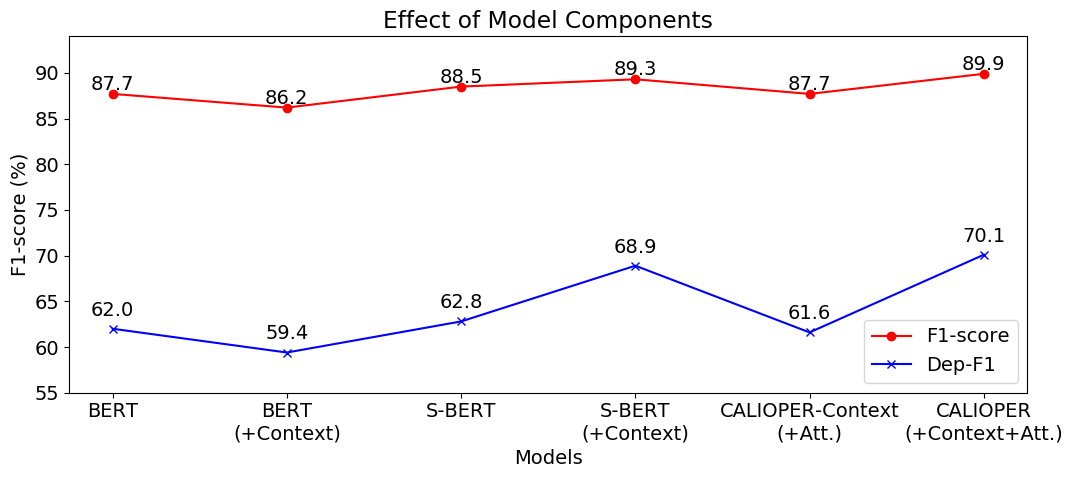

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

fig = plt.figure()

# set figsize
plt.figure(figsize=(11, 5))

# Data for the table
labels = ['BERT', 'BERT\n(+Context)', 'S-BERT', 'S-BERT\n(+Context)', 'CALIOPER-Context\n(+Att.)', 'CALIOPER\n(+Context+Att.)']
f1_scores = [100*x for x in [0.877, 0.862, 0.885, 0.893, 0.877, 0.899]]
dep_f1_scores = [100*x for x in [0.620, 0.594, 0.628, 0.68900000000000001, 0.616, 0.701]]

# Creating the line graph
x = np.arange(len(labels))

plt.plot(x, f1_scores, marker='o', linestyle='-', color='r', label='F1-score')
plt.plot(x, dep_f1_scores, marker='x', linestyle='-', color='b', label='Dep-F1')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('F1-score (%)')
plt.title('Effect of Model Components')

# Adding the data values as text on the lines
for i, j in zip(x, f1_scores):
    plt.text(i, j, str(j), ha='center', va='bottom')
for i, j in zip(x, dep_f1_scores):
    plt.text(i, j+1, str(j), ha='center', va='bottom')

# Adjusting the x-axis tick labels
plt.xticks(x, labels)
plt.ylim(55, 94)

# Displaying the legend
plt.legend(loc='lower right')

plt.savefig(
    'fig_ablative_study.pdf',
    bbox_inches='tight',
)

# Displaying the graph
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

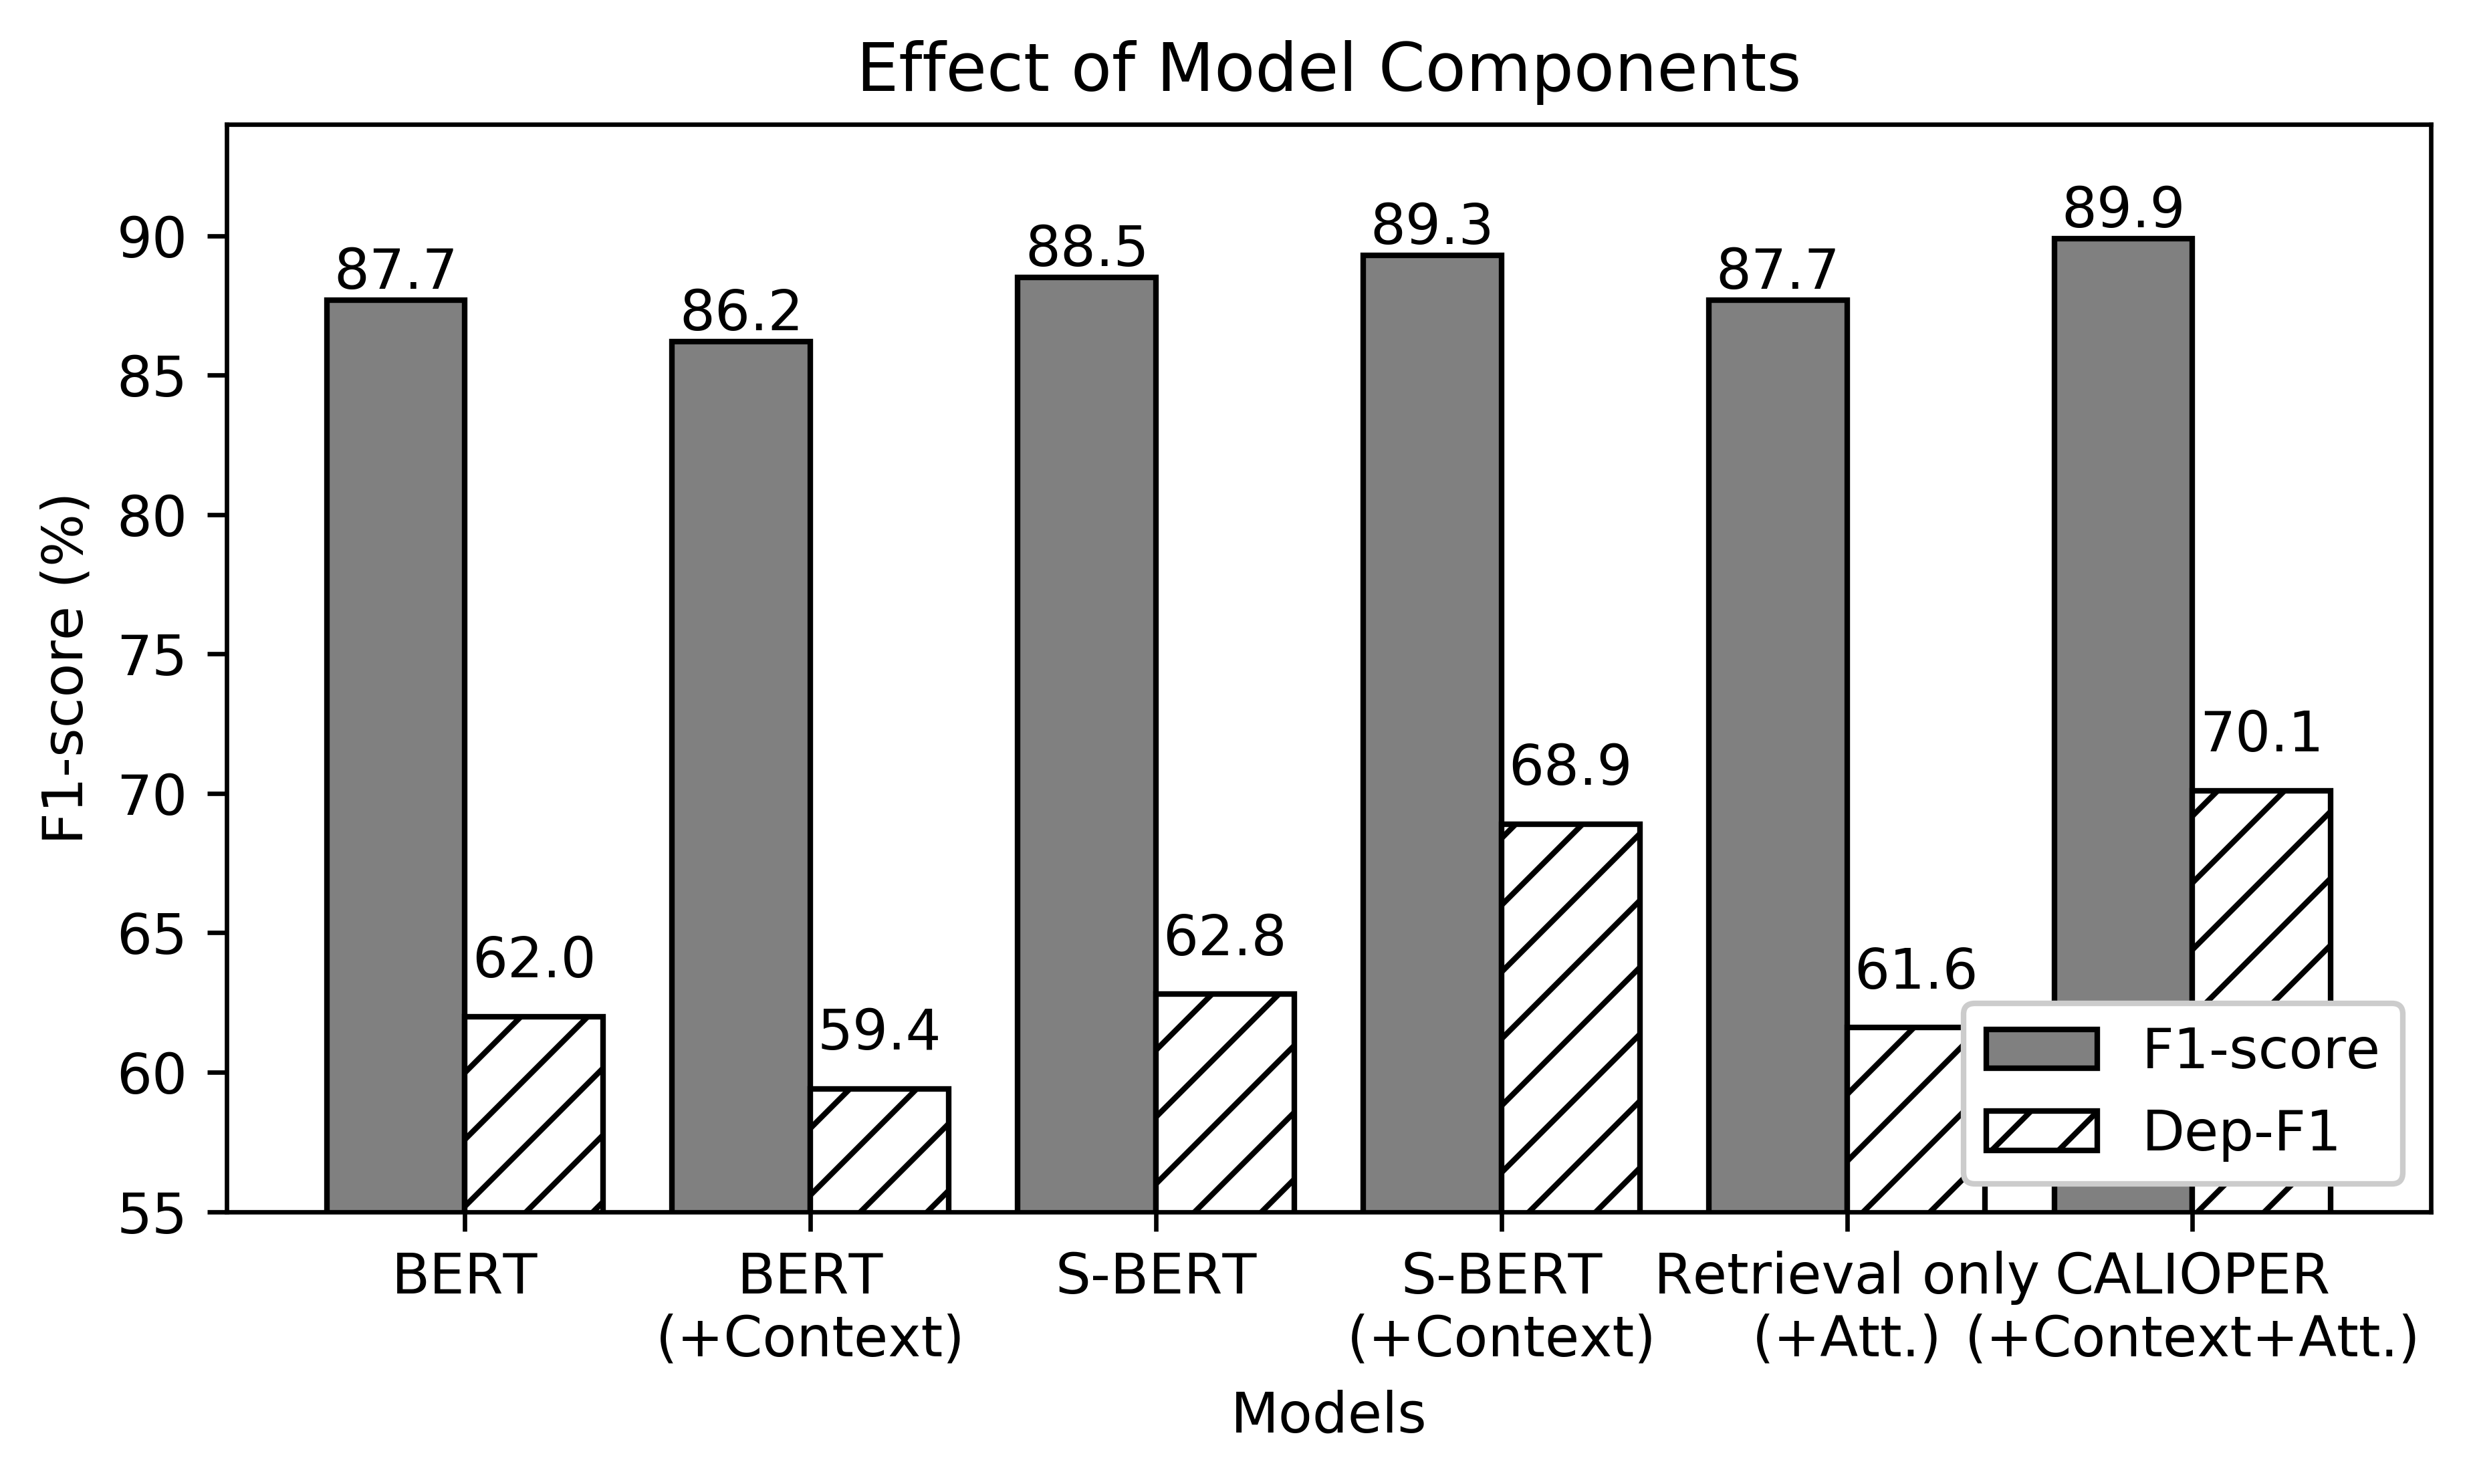

In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig = plt.figure()

# set figsize
plt.figure(figsize=(6.3, 3.8), dpi=600)

# Data for the table
labels = ['BERT', 'BERT\n(+Context)', 'S-BERT', 'S-BERT\n(+Context)', 'Retrieval only\n(+Att.)', 'CALIOPER\n(+Context+Att.)']
f1_scores = [100*x for x in [0.877, 0.862, 0.885, 0.893, 0.877, 0.899]]
dep_f1_scores = [100*x for x in [0.620, 0.594, 0.628, 0.68900000000000001, 0.616, 0.701]]

# Creating the line graph
x = np.arange(len(labels))

plt.bar(x-0.2, f1_scores, 0.4, linestyle='-', color='gray', label='F1-score',edgecolor='black')
plt.bar(x+0.2, dep_f1_scores, 0.4, linestyle='-', color='white', label='Dep-F1', edgecolor='black', hatch='//')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('F1-score (%)')
plt.title('Effect of Model Components')

# Adding the data values as text on the lines
for i, j in zip(x, f1_scores):
    plt.text(i-0.2, j, str(j), ha='center', va='bottom')
for i, j in zip(x, dep_f1_scores):
    plt.text(i+0.2, j+1, str(j), ha='center', va='bottom')

# Adjusting the x-axis tick labels
plt.xticks(x, labels)
plt.ylim(55, 94)

# Displaying the legend
plt.legend(loc='lower right', shadow=False, framealpha=1)


# Displaying the graph
plt.tight_layout()

plt.savefig(
    'fig_ablative_study.pdf',
    bbox_inches='tight',
)

plt.show()

In [10]:
train_data['split'] = 'train'
test_data['split'] = 'test'
concat_data = pd.concat([train_data, test_data], ignore_index=True)

In [12]:
concat_data.columns

Index(['file_name', 'set_no', 'session_no', 'message_no', 'author', 'text',
       'previous_utterance', 'offensive', 'context_dependent', 'type_insult',
       'type_threat', 'type_swear', 'type_sexual', 'type_toxic',
       'jigsaw_toxicity', 'jigsaw_severe_toxicity', 'jigsaw_identity_attack',
       'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat',
       'jigsaw_sexually_explicit', 'jigsaw_flirtation',
       'jigsaw_attack_on_author', 'jigsaw_attack_on_commenter',
       'jigsaw_incoherent', 'jigsaw_inflammatory', 'jigsaw_likely_to_reject',
       'jigsaw_obscene', 'jigsaw_spam', 'jigsaw_unsubstantial', 'label',
       'split'],
      dtype='object')

In [20]:
# Create table of count of each label: offensive, context_dependent, type_insult, type_threat, type_swear, type_sexual, type_toxic
concat_data.groupby(['split', 'offensive']).count()

file_name  set_no  session_no  message_no  author  text  \
split offensive                                                            
test  N               1987    1987        1987        1987    1987  1987   
      Y                329     329         329         329     329   329   
train N               7174    7174        7174        7174    7174  7174   
      Y               1781    1781        1781        1781    1781  1781   

                 previous_utterance  context_dependent  type_insult  \
split offensive                                                       
test  N                        1987               1987         1987   
      Y                         329                329          329   
train N                        7174               7174         7174   
      Y                        1781               1781         1781   

                 type_threat  ...  jigsaw_flirtation  jigsaw_attack_on_author  \
split offensive               ...                                               
test  N                 1987  ...               1987                     1987   
      Y                  329  ...                329                      329   
train N                 7174  ...               7174                     7174   
      Y                 1781  ...               1781                     1781   

                 jigsaw_attack_on_commenter  jigsaw_incoherent  \
split offensive                                                  
test  N                                1987               1987   
      Y                                 329                329   
train N                                7174               7174   
      Y                                1781               1781   

                 jigsaw_inflammatory  jigsaw_likely_to_reject  jigsaw_obscene  \
split offensive                                                                 
test  N                         1987                     1987            1987   
      Y                          329                      329             329   
train N                         7174                     7174            7174   
      Y                         1781                     1781            1781   

                 jigsaw_spam  jigsaw_unsubstantial  label  
split offensive                                            
test  N                 1987                  1987   1987  
      Y                  329                   329    329  
train N                 7174                  7174   7174  
      Y                 1781                  1781   1781  

[4 rows x 30 columns]

In [21]:
concat_data.groupby(['split', 'offensive', 'context_dependent']).count()

file_name  set_no  session_no  message_no  \
split offensive context_dependent                                              
test  N         N                       1987    1987        1987        1987   
      Y         N                        257     257         257         257   
                Y                         72      72          72          72   
train N         N                       7174    7174        7174        7174   
      Y         N                       1233    1233        1233        1233   
                Y                        548     548         548         548   

                                   author  text  previous_utterance  \
split offensive context_dependent                                     
test  N         N                    1987  1987                1987   
      Y         N                     257   257                 257   
                Y                      72    72                  72   
train N         N                    7174  7174                7174   
      Y         N                    1233  1233                1233   
                Y                     548   548                 548   

                                   type_insult  type_threat  type_swear  ...  \
split offensive context_dependent                                        ...   
test  N         N                         1987         1987        1987  ...   
      Y         N                          257          257         257  ...   
                Y                           72           72          72  ...   
train N         N                         7174         7174        7174  ...   
      Y         N                         1233         1233        1233  ...   
                Y                          548          548         548  ...   

                                   jigsaw_flirtation  jigsaw_attack_on_author  \
split offensive context_dependent                                               
test  N         N                               1987                     1987   
      Y         N                                257                      257   
                Y                                 72                       72   
train N         N                               7174                     7174   
      Y         N                               1233                     1233   
                Y                                548                      548   

                                   jigsaw_attack_on_commenter  \
split offensive context_dependent                               
test  N         N                                        1987   
      Y         N                                         257   
                Y                                          72   
train N         N                                        7174   
      Y         N                                        1233   
                Y                                         548   

                                   jigsaw_incoherent  jigsaw_inflammatory  \
split offensive context_dependent                                           
test  N         N                               1987                 1987   
      Y         N                                257                  257   
                Y                                 72                   72   
train N         N                               7174                 7174   
      Y         N                               1233                 1233   
                Y                                548                  548   

                                   jigsaw_likely_to_reject  jigsaw_obscene  \
split offensive context_dependent                                            
test  N         N                                     1987            1987   
      Y         N                                      257             257   
                Y                                       72              72   
train N

In [32]:
pd.crosstab(concat_data['split'], concat_data['type_insult'], margins=True)

type_insult,N,Y,All
split,,,
test,2293,23,2316
train,8824,131,8955
All,11117,154,11271


In [33]:
pd.crosstab(concat_data['split'], concat_data['type_threat'], margins=True)

type_threat,N,Y,All
split,,,
test,2311,5,2316
train,8916,39,8955
All,11227,44,11271


In [34]:
pd.concat( [pd.crosstab(concat_data['split'], concat_data['type_insult'], margins=True),
            pd.crosstab(concat_data['split'], concat_data['type_threat'], margins=True),
            pd.crosstab(concat_data['split'], concat_data['type_swear'], margins=True),
            pd.crosstab(concat_data['split'], concat_data['type_sexual'], margins=True),
            pd.crosstab(concat_data['split'], concat_data['type_toxic'], margins=True)], axis=1)

,N,Y,All,N,Y,All,N,Y,All,N,Y,All,N,Y,All
split,,,,,,,,,,,,,,,
test,2293,23,2316,2311,5,2316,2266,50,2316,2043,273,2316,2248,68,2316
train,8824,131,8955,8916,39,8955,8671,284,8955,7442,1513,8955,8615,340,8955
All,11117,154,11271,11227,44,11271,10937,334,11271,9485,1786,11271,10863,408,11271


In [58]:
# Count the unique tuple of (set_no, session_no) 
len(concat_data.groupby(['set_no', 'session_no']).count())

1380